# OpenAQ - Dataset Analysis

### ***↪***&nbsp;&nbsp;**Imports**

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# ================================================================
# INPUTS: change depending on the data you're working with

import os
from openaq_anomaly_prediction.config import Configuration as cfg

PARQUET_FILEPATH = os.path.join(cfg.DATA_EXPORT_PATH, "bq_int_openaq__measurements_standardized.parquet")
# PARQUET_FILEPATH = os.path.join(cfg.DATA_EXPORT_PATH, "seoul_complete.int.parquet")
# PARQUET_FILEPATH = os.path.join("seoul_complete.int.parquet")

In [3]:
%load_ext autoreload
%autoreload 2

from openaq_anomaly_prediction.load.gcp import bq

In [4]:
# ================================================================
# IMPORTS: python packages and settings (don't change anything)

import time
import requests
import gc

import duckdb
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import pyarrow.dataset as ds
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.graph_objs import Figure as PlotlyFigure

from pprint import pprint

# CONFIG: to display all rows/columns of a dataframe (debug)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.width", 1000)
SEP_LENGTH = 64  # Only so we can print separators of a fixed length

# PyArrow
parquet_file = pq.ParquetFile(PARQUET_FILEPATH)

# DuckDB:
con = duckdb.connect()
con.execute("SET TimeZone = 'UTC';")
con.execute(
    f"CREATE OR REPLACE VIEW raw_measurements AS SELECT * FROM read_parquet('{PARQUET_FILEPATH}')"
)

In [5]:
# ================================================================
# UTILS: helper functions (don't change anything)

def print_summary_request(df: pd.DataFrame, start_time: float, **kwargs) -> None:
    """Print a summary of a request."""

    # title = kwargs.get("title", "Measurements DataFrame")
    sep_length = kwargs.get("sep_length", 64)    
    end = kwargs.get("end", "")    
    
    memory_usage = df.memory_usage(index=True, deep=True).sum() / (1024**2)

    # Summary
    # print(f"{'='*sep_length}\nSUMMARY: {title}\n{'-'*sep_length}")
    print(f"> [BigQuery]: Request finished in {time.perf_counter() - start_time:.2f}s  ->  {len(df):,} rows, {memory_usage:.2f} MB{end}")

    # # Date range
    # print_datetime = False
    # if "datetimeto_local" in df.columns:
    #     datetime_column = "datetimeto_local"
    #     print_datetime = True
    # elif "ds" in df.columns:
    #     datetime_column = "ds"
    #     print_datetime = True
    # elif "datetimeto_utc" in df.columns:
    #     datetime_column = "datetimeto_utc"
    #     print_datetime = True
    # if print_datetime:
    #     print(f"From: {df[datetime_column].min()} ({datetime_column})")
    #     print(f"To  : {df[datetime_column].max()} ({datetime_column})")

    # # Unique locations
    # if "location_id" in df.columns or "unique_id" in df.columns:
    #     location_id_column = "location_id" if "location_id" in df.columns else "unique_id"
    #     print(f"{'-'*int(sep_length/3)*2}")
    #     print(f"Unique locations: {df[location_id_column].nunique()}")

def print_summary_measurements(df: pd.DataFrame, **kwargs) -> None:
    """Print a summary of the useful stats of a measurements dataframe."""

    title = kwargs.get("title", "Measurements DataFrame")
    sep_length = kwargs.get("sep_length", 64)    
    disable_pollutants = kwargs.get("disable_pollutants", False)    
    
    memory_usage = df.memory_usage(index=True, deep=True).sum() / (1024**2)

    # Summary
    print(f"{'='*sep_length}\nSUMMARY: {title}\n{'-'*sep_length}")
    print(f"Total rows  : {len(df):,}")
    print(f"Memory usage: {memory_usage:.2f} MB")

    # Date range
    if "datetimeto_local" in df.columns:
        datetime_column = "datetimeto_local"
    elif "ds" in df.columns:
        datetime_column = "ds"
    else:
        datetime_column = "datetimeto_utc"
    print(f"From: {df[datetime_column].min()} ({datetime_column})")
    print(f"To  : {df[datetime_column].max()} ({datetime_column})")

    # Unique locations
    location_id_column = "location_id" if "location_id" in df.columns else "unique_id"
    print(f"{'-'*int(sep_length/3)*2}")
    print(f"Unique locations: {df[location_id_column].nunique()}")

    # Unique pollutants
    if "sensor_name" in df.columns and not disable_pollutants:
        print(f"Unique pollutants: {df["sensor_name"].nunique()}")
        print(f"{'-'*int(sep_length/3)*1}")
        for pollutant in df["sensor_name"].unique():
            print(f"> {pollutant}")

### ***↪***&nbsp;&nbsp;**Pollutants Coverage**

#### Pollutants Functions

In [25]:
# ================================================================
# IDENTIFY THE TOP POLLUTANTS BY NUMBER OF UNIQUE LOCATIONS

class PollutantAnalysis:
    
    KEEP_TOP_N_POLLUTANTS = 6
    THRESHOLD = 0.9
    
    def __init__(self) -> None:
        self.eda_df = pd.DataFrame()
        
        self.top_pollutants_name = []
        self.least_common_pollutant = ""
        
        self.full_locations = []
        self.partial_locations = []
    
    # ----------------------------------------------------------------
    # IDENTIFY THE TOP POLLUTANTS BY NUMBER OF UNIQUE LOCATIONS
    
    def pollutants_identify_top_pollutants(self, keep_top_n: int = 6) -> None:
        """Identify the top pollutants by number of unique locations measuring them."""
        
        KEEP_TOP_N_POLLUTANTS = PollutantAnalysis.KEEP_TOP_N_POLLUTANTS
        
        title = "IDENTIFYING TOP POLLUTANTS BY NUMBER OF UNIQUE LOCATIONS MEASURING THEM"
        print(f"{'='*len(title)}\n{title}\n")
        
        # Big Query
        start_time = time.perf_counter()
        query = """
            SELECT
                sensor_name,
                COUNT(DISTINCT location_id) AS location_count,
                COUNT(*) AS measurement_count
            FROM `openaq-anomaly-prediction.dev_intermediate.int_openaq__measurements_standardized`
            GROUP BY 1
            ORDER BY location_count DESC, measurement_count DESC
        """
        query_parameters = [
            # ("test_locations_ids", "STRING", ["12", "34", "56"]),
        ]
        self.eda_df = bq.query(query, query_parameters=query_parameters, dry_run=False)
        print_summary_request(self.eda_df, start_time)

        # Results
        display(self.eda_df.head(50))

        self.top_pollutants_name = self.eda_df.iloc[:6]["sensor_name"].tolist()
        self.least_common_pollutant = self.eda_df.iloc[KEEP_TOP_N_POLLUTANTS - 1]["sensor_name"]

        message =  f"KEEPING the top {KEEP_TOP_N_POLLUTANTS} pollutants by number of unique locations:\n"
        message += f"\n=> Unique locations: {self.eda_df['location_count'].values[0]} locations"
        message += f"\n=> Unique sensors  : {self.eda_df.iloc[:KEEP_TOP_N_POLLUTANTS]['location_count'].sum()} sensors"
        message += f"\n=> Measurements    : {self.eda_df.iloc[:KEEP_TOP_N_POLLUTANTS]['measurement_count'].sum():,}"
        message += f"\n\n{self.top_pollutants_name}"
        message += f"\n\nLeast common pollutant: ['{self.least_common_pollutant}']"
        print(f"{message}\n")
        # print(f"\n{'_'*len(title)}")
    
    
    # ----------------------------------------------------------------
    # CHECK THE POLLUTANTS COVERAGE FOR ALL CURRENT LOCATIONS

    def pollutants_check_coverage(self) -> None:
        """Check the pollutants coverage for all current locations measuring the least common pollutant."""
        
        KEEP_TOP_N_POLLUTANTS = PollutantAnalysis.KEEP_TOP_N_POLLUTANTS

        title = "POLLUTANTS COVERAGE FOR ALL LOCATIONS MEASURING THE LEAST COMMON POLLUTANT"
        print(f"{'='*len(title)}\n{title}")

        if self.eda_df.empty:
            print("=> ERROR: pollutants_identify_top_pollutants() needs to be run first (self.eda is not defined)\n")
            return
        
        print(f"\nChecking every location ({self.eda_df.iloc[KEEP_TOP_N_POLLUTANTS - 1]['location_count']}) measuring the least common pollutant \nto check if they also measure all of the top pollutants ({KEEP_TOP_N_POLLUTANTS}):\n")

        # Big Query: THIS HAS BEEN PREFILTERED FOR THE TOP 6 POLLUTANTS
        start_time = time.perf_counter()
        query = """
            WITH least_common_pollutant_locations AS (
                SELECT location_id
                FROM `openaq-anomaly-prediction.dev_intermediate.int_openaq__measurements_standardized`
                WHERE sensor_name = @least_common_pollutant GROUP BY location_id
            ),
            filtered_by_top_pollutants AS (
                SELECT location_id, sensor_name 
                FROM `openaq-anomaly-prediction.dev_intermediate.int_openaq__measurements_standardized` 
                WHERE sensor_name IN UNNEST(@top_pollutants_name)
            )
            
            SELECT 
                filtered.location_id, 
                COUNT(DISTINCT filtered.sensor_name) as pollutant_count
            FROM filtered_by_top_pollutants filtered
            INNER JOIN least_common_pollutant_locations lcl
            ON filtered.location_id = lcl.location_id
            GROUP BY filtered.location_id
        """
        query_parameters = [
            ("least_common_pollutant", "STRING", self.least_common_pollutant),
            ("top_pollutants_name", "STRING", self.top_pollutants_name),
        ]
        results = bq.query(query, query_parameters=query_parameters, dry_run=False)
        print_summary_request(results, start_time, end="\n")
        
        # Results
        self.full_locations = []
        self.partial_locations = []
        total_pollutants = len(self.top_pollutants_name)
        total_locations = len(results)
        id_max_length = max(len(str(id)) for id in results["location_id"].values.tolist())

        for index, row in results.iterrows():
            if row["pollutant_count"] == total_pollutants:
                self.full_locations.append(row["location_id"])
                # print(f"> Location {row['location_id']:<{id_max_length}} : {row['pollutant_count']}/{total_pollutants}")
            else:
                self.partial_locations.append(row["location_id"])
                print(f"> [PARTIAL] Location {row['location_id']:<{id_max_length}} : {row['pollutant_count']}/{total_pollutants}")

        if len(self.partial_locations) == 0:
            print("=> ALL LOCATIONS MEASURE ALL TOP POLLUTANTS (from the least common pollutant group).")
            print("   This test only measure if a location measures at least once each pollutant,\n   neither the frequency nor data quality for each location.")

        message = f"\nLocations coverage for the top pollutants (DuckDB): {len(self.full_locations)/total_locations:.2%} ({len(self.full_locations)}/{total_locations} locations)\n{self.full_locations}\n"
        print(f"{message}")
        # print(f"{'_'*len(title)}")
        
        
    # ----------------------------------------------------------------
    # MEASUREMENTS COVERAGE PER LOCATION FOR THE TOP POLLUTANTS
    
    def pollutants_measurements_coverage(self) -> None:
        """Measure the measurements coverage per location for the top pollutants."""
        
        THRESHOLD = PollutantAnalysis.THRESHOLD

        title = "MEASUREMENTS COVERAGE PER LOCATION OVER THE WHOLE PERIOD"
        print(f"{'=' * SEP_LENGTH}\n{title}\n")

        # Big Query: THIS HAS BEEN PREFILTERED FOR THE TOP 6 POLLUTANTS
        start_time = time.perf_counter()
        query = """
            SELECT
                location_id,
                sensor_name,
                COUNT(*) AS measurement_count,
                MIN(datetimeto_utc) AS min_datetime,
                MAX(datetimeto_utc) AS max_datetime
            FROM `openaq-anomaly-prediction.dev_intermediate.int_openaq__measurements_standardized`
            WHERE sensor_name IN UNNEST(@top_pollutants_name)
            AND location_id IN UNNEST(@full_locations)
            GROUP BY location_id, sensor_name
            ORDER BY location_id, sensor_name
        """
        query_parameters = [
            ("full_locations", "STRING", self.full_locations),
            ("top_pollutants_name", "STRING", self.top_pollutants_name),
        ]
        filtered_df = bq.query(query, query_parameters=query_parameters, dry_run=False)
        print_summary_request(filtered_df, start_time, end="\n")
        
        # Maximum possible hours in the period
        min_date = pd.Timestamp(filtered_df["min_datetime"].min())
        max_date = pd.Timestamp(filtered_df["max_datetime"].max())
        hourly_index = pd.date_range(
            start=min_date,
            end=max_date,
            freq='h'
        )
        number_of_hours = len(hourly_index)

        # Pivot filtered_df in a matrix (rows=locations, columns=pollutants)
        # TODO: Should also be done in DuckDB directly but whatever for now
        coverage_matrix = filtered_df.pivot(index="location_id", columns="sensor_name", values="measurement_count").fillna(0) / number_of_hours
        coverage_matrix["average"] = coverage_matrix.mean(axis=1)
        coverage_matrix = coverage_matrix.sort_values(by="average", ascending=False)

        kept_mask = (coverage_matrix >= THRESHOLD).all(axis=1)

        KEPT_LOCATIONS = kept_mask[kept_mask].index.tolist()
        DROPPED_LOCATIONS = kept_mask[~kept_mask].index.tolist()

        print(f"KEPT LOCATIONS with {THRESHOLD:.2%} hourly coverage for all pollutants ({len(KEPT_LOCATIONS)}/{len(self.full_locations)}):\n")
        # display(coverage_matrix[kept_mask].head(200))

        message = f"{len(KEPT_LOCATIONS)}/{len(self.full_locations)} locations with more than {THRESHOLD:.2%} hourly coverages for each pollutant:\n{KEPT_LOCATIONS}"
        print(f"{message}\n\n{'_'*SEP_LENGTH}\n")
        # print(f"\n{'='*SEP_LENGTH}\n\n{message}\n\n{'_'*SEP_LENGTH}")


        note = """For both the XGBoostRegressor and the AutoEncoder, we are NOT using continuous
data over the entire period of time so this filtering is purely informative.
We will be using segments of data (at least 14 days long) to train the XGBoost
model, and perfect hours with all pollutants measured to train the AutoEncoder
regardless of the actual full coverage of each location."""
        print(f"{note}")

        print(f"\n{'_' * SEP_LENGTH}\n")

        name_max_length = max(len(name) for name in self.top_pollutants_name)
        for loc_id, row in coverage_matrix[kept_mask].iterrows():
            min_pollutant = row.values.min()
            location_string = f"LOCATION {loc_id}: {min_pollutant:>6.2%} => GOOD COVERAGE"
            # for pollutant in top_pollutants_name:
            #     cov = row.get(pollutant, 0)
            #     location_string += f"\n  - {pollutant:<{name_max_length}} : {cov:>7.2%} | {int(cov * number_of_hours)}/{number_of_hours}"
            # location_string += "\n"
            print(location_string)
            
                
        for loc_id, row in coverage_matrix[~kept_mask].iterrows():
            min_pollutant = row.values.min()
            location_string = f"LOCATION {loc_id}: {min_pollutant:>6.2%} => SKIPPED"
            # for pollutant in top_pollutants_name:
            #     cov = row.get(pollutant, 0)
            #     location_string += f"\n  - {pollutant:<{name_max_length}} : {cov:>7.2%} | {int(cov * number_of_hours)}/{number_of_hours}"
            # location_string += "\n"
            print(location_string)

        print()
        
def pollutants_report() -> None:
    pa = PollutantAnalysis()
    pa.pollutants_identify_top_pollutants()
    pa.pollutants_check_coverage()
    pa.pollutants_measurements_coverage()

#### Pollutants Report

In [50]:
pollutants_report()

IDENTIFYING TOP POLLUTANTS BY NUMBER OF UNIQUE LOCATIONS MEASURING THEM

> [BigQuery]: Request finished in 1.49s  ->  10 rows, 0.00 MB


,sensor_name,location_count,measurement_count
0,pm25 µg/m³,127,1534251
1,o3 ppm,124,1521536
2,co ppm,124,1521530
3,no2 ppm,124,1521493
4,so2 ppm,124,1520910
5,pm10 µg/m³,124,1520612
6,temperature c,2,6429
7,relativehumidity %,2,6333
8,pm1 µg/m³,1,6220
9,um003 particles/cm³,1,6220


KEEPING the top 6 pollutants by number of unique locations:

=> Unique locations: 127 locations
=> Unique sensors  : 747 sensors
=> Measurements    : 9,140,332

['pm25 µg/m³', 'o3 ppm', 'co ppm', 'no2 ppm', 'so2 ppm', 'pm10 µg/m³']

Least common pollutant: ['pm10 µg/m³']

POLLUTANTS COVERAGE FOR ALL LOCATIONS MEASURING THE LEAST COMMON POLLUTANT

Checking every location (124) measuring the least common pollutant 
to check if they also measure all of the top pollutants (6):

> [BigQuery]: Request finished in 1.39s  ->  124 rows, 0.01 MB

=> ALL LOCATIONS MEASURE ALL TOP POLLUTANTS (from the least common pollutant group).
   This test only measure if a location measures at least once each pollutant,
   neither the frequency nor data quality for each location.

Locations coverage for the top pollutants (DuckDB): 100.00% (124/124 locations)
['2623194', '2623190', '2623004', '2622807', '2623134', '2623276', '2623321', '2623367', '2622848', '2623474', '2623465', '2623537', '2623154', '262274

### ***↪***&nbsp;&nbsp;**Segments Analysis (shattering)**

##### Segments Functions

In [19]:
# =====================================================================
# COMPARISON OF STRATEGIES OF SHATTERING / SEGMENTATION

def assert_segments_summary(segments_df: pd.DataFrame):
    total_rows = len(segments_df)
    total_nan = segments_df[["pm25_ugm3", "pm10_ugm3", "no2_ppm", "o3_ppm", "so2_ppm", "co_ppm"]].isna().sum().sum()

    title = "STRATEGY A: Time since last PERFECT hour (all sensors reporting)"
    print(f"{'='*SEP_LENGTH}\n{title}\n{'='*SEP_LENGTH}\n")
    print("=> [GOLD]: segment with >=14 days of continuous perfect hours")
    print("=> [4H]: max gap between 2 perfect hours in a unique segment\n")
    print(f"{total_rows:,} total rows -> {total_nan:,} NaNs = {total_nan/total_rows:.2%} ({segments_df['segment_id'].nunique():,} segments)")
    print(f"\n{'-'*SEP_LENGTH}")

    # ALL SEGMENTS
    print("[ALL SEGMENTS]:\n")
    for tier in ["gold", "silver", "bronze"]:
        tier_df = segments_df[segments_df["segment_tier"] == tier]
        tier_rows = len(tier_df)
        tier_nan = tier_df[["pm25_ugm3", "pm10_ugm3", "no2_ppm", "o3_ppm", "so2_ppm", "co_ppm"]].isna().sum().sum()
        tier_segments = tier_df['segment_id'].nunique()
        print(f" - {tier.upper():7}: {f'{tier_rows:,} rows':>15} | {f'{tier_nan:,} NaNs':>12} {f'({tier_nan/tier_rows:.2%})':>8} | {f'{tier_df['segment_id'].nunique():,}':>5} segments")
    print(f"\n{'-'*SEP_LENGTH}")

    # ALL SEGMENTS WITH PERFECT DENSITY FILTER
    density_threshold = 0.9
    print(f"[SEGMENTS WITH PERFECT DENSITY >= {density_threshold}]:\n")
    for tier in ["gold", "silver", "bronze"]:
        tier_df = segments_df[(segments_df["segment_tier"] == tier) & (segments_df["segment_perfect_density"] >= density_threshold)]
        tier_rows = len(tier_df)
        tier_nan = tier_df[["pm25_ugm3", "pm10_ugm3", "no2_ppm", "o3_ppm", "so2_ppm", "co_ppm"]].isna().sum().sum()
        print(f" - {tier.upper():7}: {f'{tier_rows:,} rows':>15} | {f'{tier_nan:,} NaNs':>12} {f'({tier_nan/tier_rows:.2%})':>8} | {f'{tier_df['segment_id'].nunique():,}':>5} segments")
    
    print()

In [20]:
# =====================================================================
# ASSERT: SEGMENTS OVERLAP TEST

def assert_segments_overlap():
    title = "TESTING SEGMENTS OVERLAP"
    print(f"{'='*SEP_LENGTH}\n{title}\n{'='*SEP_LENGTH}\n")
    
    # BigQuery
    start_time = time.perf_counter()
    query = """
        WITH segment_boundaries AS (
            SELECT 
                location_id,
                segment_id,
                segments_num,
                MIN(datetimeto_utc) AS segment_start,
                MAX(datetimeto_utc) AS segment_end
            FROM `openaq-anomaly-prediction.dev_intermediate.int_seoul__measurements_segments`
            GROUP BY location_id, segment_id, segments_num
        ),
        overlapping_segments AS (
            SELECT 
                *,
                -- Get the end time of the segment that started just before this one
                LAG(segment_end) OVER (
                    PARTITION BY location_id 
                    ORDER BY segment_start ASC
                ) AS prev_segment_end,
                -- Time difference in hours between the start of the current segment and the end of the previous segment
                DATETIME_DIFF(segment_start, LAG(segment_end) OVER (PARTITION BY location_id ORDER BY segment_start ASC), HOUR) AS hours_since_prev_segment_end,
                -- Check for overlap: If the current start is BEFORE the previous end
                CASE 
                    WHEN segment_start < LAG(segment_end) OVER (PARTITION BY location_id ORDER BY segment_start ASC) 
                    THEN TRUE 
                    ELSE FALSE 
                END AS is_overlapping
            FROM segment_boundaries
            ORDER BY location_id, segment_start ASC
        )
        SELECT
            *
        FROM overlapping_segments
        WHERE is_overlapping = TRUE
    """
    query_parameters = [
        # ("test_locations_ids", "STRING", TEST_LOCATIONS)
        # ("selected_location", "STRING", "2622586")
    ]
    overlap_df = bq.query(query, query_parameters=query_parameters, dry_run=False)
    print_summary_request(overlap_df, start_time, end="")

    if len(overlap_df) == 0:
        print(f"> [OK] No overlapping segments found ({len(overlap_df)} row).")
    else:
        print(f"> [ERROR] Overlapping segments found ({len(overlap_df)} rows).")
    
    print()

In [21]:
# ================================================================
# SEGMENTS ANALYSIS: Segments Duration and Counts

# ONLY
# ALL HISTORIC DATA: 8,390,246 measurements (too noisy in the beginning)
# From 2024-05-01  : 8,157,409 measurements (10,569,834 total) -> 77.2% of the data in gold segments (4076/6567 segments)
# From 2024-08-01  : 6,922,251 measurements (7,929,342 total) -> 87.3% of the data in gold segments (3184/5341 segments)

# Starting in May 2024, we get less coverage but we still have more volume without losing too much compared to the full historic data.

def assert_segments_analysis(df: pd.DataFrame) -> None:
    title = "CONTINUOUS SEGMENTS ANALYSIS"
    print(f"{'=' * SEP_LENGTH}\n{title}\n{'='*SEP_LENGTH}\n")

    # TIME SERIES PERIOD (MAXIMUM POTENTIAL MEASUREMENTS)
    min_date = pd.Timestamp(df["datetimeto_utc"].min())
    max_date = pd.Timestamp(df["datetimeto_utc"].max())
    hourly_index = pd.date_range(start=min_date, end=max_date, freq='h')
    number_of_hours = len(hourly_index)
    maximum_potential_measurements = number_of_hours*df['location_id'].nunique()
    print(f"Total Hours in the period: {number_of_hours} hours \nFrom: {min_date}\nTo  : {max_date}")
    print(f"Maximum potential measurements: {maximum_potential_measurements:,} measurements")

    # note = """For the time-series with XGBoost, we need segments of sufficient duration to capture the 
    # temporal patterns and trends in the data but we don't need perfect data coverage for every location,
    # as the model is trained per pollutant/sensor independently. We would still use the top perfect locations
    # (= 6 pollutants measured most of the time) as the test sample to evaluate the model performance and train
    # the model on every other location with gold segments.

    # For the AutoEncoder, we don't need segments (or continuous data) but we need to train the model on hours
    # where we have ALL the pollutants measured at once in the same location. That being said, we would still
    # use the top perfect gold locations as the test sample to evaluate the AutoEncoder."""
    # print(f"\n{note}")


    # SEGMENTS GROUPED BY DURATION
    print(f"\n{'-' * SEP_LENGTH}")
    # note = """Because we have 1 measurement per hour per sensor and per location, each segment duration in hours
    # also represents the number of measurements. For example, a segment with 168 hours duration has
    # 168 measurements for that sensor/location combination. Any hours outside of those segments
    # are large time gaps (>= 6 hours) in the data that are being ignored."""
    # print(f"\n{note}")

    groupby_segment_duration = df.groupby("segment_id")["segment_total_hours"].max()

    # SEGMENTS MEASUREMENTS COVERAGE
    total_segments_duration = groupby_segment_duration.sum()
    total_segments_duration_48h = groupby_segment_duration[groupby_segment_duration >= 48].sum()
    total_segments_duration_72h = groupby_segment_duration[groupby_segment_duration >= 72].sum()
    total_segments_duration_168h = groupby_segment_duration[groupby_segment_duration >= 168].sum()
    total_segments_duration_336h = groupby_segment_duration[groupby_segment_duration >= 336].sum()
    print(f"\nTOTAL MEASUREMENTS ACROSS ALL SEGMENTS  : {total_segments_duration/maximum_potential_measurements:.2%}  ->  {total_segments_duration:,}/{maximum_potential_measurements:,} measurements")
    print(f"Total duration for segments >=48 hours  : {total_segments_duration_48h/maximum_potential_measurements:.2%}  ->  {total_segments_duration_48h:,}/{maximum_potential_measurements:,} measurements")
    print(f"Total duration for segments >=72 hours  : {total_segments_duration_72h/maximum_potential_measurements:.2%}  ->  {total_segments_duration_72h:,}/{maximum_potential_measurements:,} measurements")
    print(f"Total duration for segments >=168 hours : {total_segments_duration_168h/maximum_potential_measurements:.2%}  ->  {total_segments_duration_168h:,}/{maximum_potential_measurements:,} measurements")
    print(f"Total duration for segments >=336 hours : {total_segments_duration_336h/maximum_potential_measurements:.2%}  ->  {total_segments_duration_336h:,}/{maximum_potential_measurements:,} measurements => GOLD")

    # SEGMENTS DISTRIBUTION (TIERS)
    total_segments = df['segment_id'].nunique()
    total_segments_count_48h = df[df["segment_total_hours"] >= 48]["segment_id"].nunique()
    total_segments_count_72h = df[df["segment_total_hours"] >= 72]["segment_id"].nunique()
    total_segments_count_168h = df[df["segment_total_hours"] >= 168]["segment_id"].nunique()
    total_segments_count_336h = df[df["segment_total_hours"] >= 336]["segment_id"].nunique()
    print(f"\nNUMBER OF SEGMENTS   : {total_segments} (100%)")
    print(f"Segments >=48 hours  : {total_segments_count_48h} ({total_segments_count_48h/total_segments:.2%})")
    print(f"Segments >=72 hours  : {total_segments_count_72h} ({total_segments_count_72h/total_segments:.2%})")
    print(f"Segments >=168 hours : {total_segments_count_168h} ({total_segments_count_168h/total_segments:.2%})")
    print(f"Segments >=336 hours : {total_segments_count_336h} ({total_segments_count_336h/total_segments:.2%}) => GOLD ({df[df["segment_tier"] == "gold"]["segment_id"].nunique()})")

    # print(f"\n{'-' * SEP_LENGTH}")
    # note = """When comparing the dataset between ALL the gold segments and ONLY the gold segments
    # with >0.9 density, we get more or less the same number of NaNs for barely more
    # """
    # print(f"\n{note}")
    
    print()

# assert_segments_analysis(segments_df)


In [22]:
# =====================================================================
# SEGMENTS PLOT: GOLD SEGMENTS COVERAGE PER LOCATION

def assert_plot_segments_overview(segments_df: pd.DataFrame, date_mask=None, **kwargs) -> None:
    
    title_suffix = kwargs.get("title_suffix", "")
    if title_suffix == "":
        title_suffix = ": GOLD SEGMENTS COVERAGE PER LOCATION"

    title = f"SEGMENTS PLOT{title_suffix}"
    print(f"{'=' * SEP_LENGTH}\n{title}\n{'='*SEP_LENGTH}\n")
    
    filtered_df = segments_df[date_mask].copy() if date_mask is not None else segments_df.copy()
    
    for idx, location in enumerate(filtered_df["location_id"].unique()):
        location_df = filtered_df[
            filtered_df["location_id"] == location
        ]

        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 3))

        gold_segments = location_df[location_df["segment_tier"] == "gold"]
        total_gold_segments = gold_segments["segment_id"].nunique()

        bar_spacing = 6
        bar_height = 8

        for idx_seg, segment_id in enumerate(gold_segments["segment_id"].unique()):
            segment_df = gold_segments[(gold_segments["segment_id"] == segment_id)]
            start = segment_df["segment_start"].iloc[0]
            total_hours = segment_df["segment_total_hours"].iloc[0]
            density = segment_df["segment_perfect_density"].iloc[0]

            # Durations for plotting
            full_duration = pd.to_timedelta(total_hours, unit="h")
            # perfect_duration = pd.to_timedelta(total_hours * density, unit="h")

            y_pos = idx_seg * bar_spacing

            color = (
                "#2ecc71"
                if density >= 0.9
                else "#f39c12"
                if density >= 0.8
                else "#e74c3c"
            )
            # 1. Plot Background (The "Total" possible duration)
            ax.broken_barh(
                [(start, full_duration)],
                (y_pos, bar_height),
                color=color,
                alpha=0.9,
                label="",
            )

            # Formatting
            ax.set_ylim(-bar_height + 2, total_gold_segments * bar_spacing + bar_height)
            ax.set_yticklabels("")

        # ax.set_ylim(-(bar_spacing/2), len(gold_segments["segment_id"].unique()) * bar_spacing + bar_spacing)
        ax.grid(True, axis="x", linestyle="--", alpha=0.7)
        
        plt.title(
            f"Location {location} - {gold_segments['segment_id'].nunique()} gold segments ({gold_segments['segments_total'].max()} total)"
        )
        plt.xlabel("Datetime (UTC)")
        plt.ylabel("Gold Segments")
        plt.tight_layout()
        plt.show()
        plt.close(fig)

        # if idx >= 10:
        #     break

In [23]:
# =====================================================================
# SEGMENTS PLOT: DISTRIBUTION OF PERFECT HOURS DENSITY
 
def assert_plot_perfect_density_distribution(segments_df) -> None:

    title = "SEGMENTS PLOT: DISTRIBUTION OF PERFECT HOURS DENSITY"
    print(f"{'=' * SEP_LENGTH}\n{title}\n{'='*SEP_LENGTH}\n")
        
    unique_segments = segments_df.drop_duplicates(subset=['segment_id'])

    plt.figure(figsize=(10, 3))
    sns.histplot(unique_segments['segment_perfect_density'], bins=20, kde=True, color='gold')

    plt.title('Distribution of the Density of Perfect Hours in Segments')
    plt.xlabel('Density (0.0 to 1.0)')
    plt.ylabel('Count of Segments')
    plt.grid(axis='y', alpha=0.3)
    plt.show()

In [24]:
# =====================================================================
# PERFECT GOLD LOCATIONS
 
def get_perfect_gold_locations(segments_df: pd.DataFrame, **kwargs) -> list:
    title_suffix = kwargs.get("title_suffix", "")
    mask = kwargs.get("mask", True)
    
    title = f"PERFECT GOLD LOCATIONS{title_suffix}"
    print(f"{'=' * SEP_LENGTH}\n{title}\n{'='*SEP_LENGTH}\n")
    
    # SELECTED LOCATIONS (GOLD SEGMENTS)
    PERFECT_GOLD_LOCATIONS = segments_df[(segments_df["segment_tier"] == "gold") & mask]["location_id"].unique().tolist()
    print(f"Selected locations from gold segments (>=336 hours): {len(PERFECT_GOLD_LOCATIONS)}/{segments_df['location_id'].nunique()} locations")
    print(f"\n{PERFECT_GOLD_LOCATIONS}\n")
    
    return PERFECT_GOLD_LOCATIONS

# PERFECT_GOLD_LOCATIONS = get_perfect_gold_locations(
#     segments_df,
#     # title_suffix=" WITH PERFECT DENSITY >= 0.9",
#     # mask=(segments_df["segment_perfect_density"] >= 0.9)
# )


##### Segments Report

In [66]:
# =====================================================================
# COMPARISON OF STRATEGIES OF SHATTERING / SEGMENTATION
# =====================================================================

# Conclusion: we'll start with the Strategy A with a 4h gap threshold
# as it gives us a good balance between data volume and data quality.
# [STRATEGY A + 4H IS THE GOAT]

# ----------------------------------------------------------------
# BQ QUERY: int_seoul__measurements_segments 

# V2 PIVOT TABLE + SEGMENTS (standardized > pivoted > segments)
# 1/ We pivot
# 2/ We add segments info
# 3/ We filter only perfect segments with multivariate continuity (<=4h gaps)

title = "COMPARISON OF STRATEGIES OF SHATTERING / SEGMENTATION"
print(f"{'=' * SEP_LENGTH}\n{title}\n{'='*SEP_LENGTH}\n")

# Big Query
start_time = time.perf_counter()
query = """
    SELECT
        * 
        -- * EXCEPT (segment_perfect_hours, segment_perfect_density)
    FROM `openaq-anomaly-prediction.dev_intermediate.int_seoul__measurements_segments`
    --WHERE location_id = @selected_location
    ORDER BY location_id, datetimeto_utc ASC
"""
query_parameters = [
    # ("test_locations_ids", "STRING", TEST_LOCATIONS)
    ("selected_location", "STRING", "2622586")
]
segments_df = bq.query(query, query_parameters=query_parameters, dry_run=False)
print_summary_request(segments_df, start_time, end="")

display(segments_df.head(5))
# display(segments_df.iloc[1510:][columns].head(250))  # 355 - 1510
# display(segments_df.iloc[355:].head(250))  # 355 - 1530
# segments_df.info()

# ----------------------------------------------------------------
# SEGMENTS REPORT

assert_segments_summary(segments_df)
assert_segments_overlap()
assert_segments_analysis(segments_df)

PERFECT_GOLD_LOCATIONS = get_perfect_gold_locations(
    segments_df,
    # title_suffix=" WITH PERFECT DENSITY >= 0.9",
    # mask=(segments_df["segment_perfect_density"] >= 0.9)
)

# ----------------------------------------------------------------
# SEGMENTS PLOTS

# # PLOT: DENSITY OF PERFECT HOURS DISTRIBUTION
# assert_plot_perfect_density_distribution(segments_df)

# # PLOT: SEGMENTS OVERVIEW (FULL PERIOD)
# # WARNING: THIS WILL MAKE 1 PLOT PER LOCATION (100+ LOCATIONS)
# date_mask = (segments_df["datetimeto_utc"] >= "2025-02-24") & (segments_df["datetimeto_utc"] < "2025-03-25")
# mask = True
# assert_plot_segments_overview(segments_df, date_mask)

# ----------------------------------------------------------------
# UNLOAD SEGMENTS DATAFRAME
segments_df = None
del segments_df
unreachable = gc.collect()

COMPARISON OF STRATEGIES OF SHATTERING / SEGMENTATION

> [BigQuery]: Request finished in 2.80s  ->  1,355,009 rows, 403.13 MB


,location_id,datetimeto_utc,hours_since_last,concurrent_sensors,is_new_segment,pm25_ugm3,pm10_ugm3,no2_ppm,o3_ppm,so2_ppm,co_ppm,segment_id,segment_start,segment_end,segment_perfect_hours,segment_total_hours,segment_perfect_density,segment_tier,segments_num,segments_total
0,2622586,2024-04-30 15:00:00+00:00,<NA>,6,1,43.0,68.0,0.0328,0.0264,0.0036,0.56,2622586_S1,2024-04-30 15:00:00+00:00,2024-05-15 15:00:00+00:00,357,361,0.98892,gold,1,62
1,2622586,2024-04-30 16:00:00+00:00,1,6,0,24.0,39.0,0.0105,0.0461,0.0033,0.30,2622586_S1,2024-04-30 15:00:00+00:00,2024-05-15 15:00:00+00:00,357,361,0.98892,gold,1,62
2,2622586,2024-04-30 17:00:00+00:00,1,6,0,8.0,15.0,0.0071,0.0474,0.0030,0.26,2622586_S1,2024-04-30 15:00:00+00:00,2024-05-15 15:00:00+00:00,357,361,0.98892,gold,1,62
3,2622586,2024-04-30 18:00:00+00:00,1,6,0,4.0,13.0,0.0064,0.0471,0.0023,0.25,2622586_S1,2024-04-30 15:00:00+00:00,2024-05-15 15:00:00+00:00,357,361,0.98892,gold,1,62
4,2622586,2024-04-30 19:00:00+00:00,1,6,0,7.0,17.0,0.0077,0.0462,0.0024,0.27,2622586_S1,2024-04-30 15:00:00+00:00,2024-05-15 15:00:00+00:00,357,361,0.98892,gold,1,62


STRATEGY A: Time since last PERFECT hour (all sensors reporting)

=> [GOLD]: segment with >=14 days of continuous perfect hours
=> [4H]: max gap between 2 perfect hours in a unique segment

1,355,009 total rows -> 140,390 NaNs = 10.36% (3,978 segments)

----------------------------------------------------------------
[ALL SEGMENTS]:

 - GOLD   :  1,121,745 rows | 107,872 NaNs  (9.62%) | 1,124 segments
 - SILVER :    121,328 rows |  14,960 NaNs (12.33%) |   504 segments
 - BRONZE :    111,936 rows |  17,558 NaNs (15.69%) | 2,350 segments

----------------------------------------------------------------
[SEGMENTS WITH PERFECT DENSITY >= 0.9]:

 - GOLD   :  1,107,719 rows | 103,240 NaNs  (9.32%) | 1,098 segments
 - SILVER :    106,002 rows |   8,857 NaNs  (8.36%) |   435 segments
 - BRONZE :     84,715 rows |   5,836 NaNs  (6.89%) | 1,764 segments

TESTING SEGMENTS OVERLAP

> [BigQuery]: Request finished in 1.35s  ->  0 rows, 0.00 MB
> [OK] No overlapping segments found (0 row).

CONTINUO

### ***↪***&nbsp;&nbsp;**Train/Test Discovery**

#### _Archives_

In [254]:
# ARCHIVES: DISTRIBUTION OF TIME GAPS BETWEEN MEASUREMENTS

# # ================================================================
# # SEGMENTS ANALYSIS: Segments Duration and Counts

# # Filter out both the interpolated and extreme gaps for visualization
# df_analyzed = df[(df["hours_since_prev"] >= 6) & (df["hours_since_prev"] <= 10000)]

# # Plotting
# fig, axes = plt.subplots(figsize=(16, 4), nrows=1, ncols=2, gridspec_kw={'width_ratios': [5, 4]})

# for label, group in df_analyzed.groupby(['location_id', 'sensor_name']):
#     axes[0].scatter(
#         group['datetimeto_utc'], 
#         group['hours_since_prev'], 
#         label=label, 
#         alpha=0.7, 
#         s=15
#     )
# axes[0].set_title("Time Gaps Between Consecutive Measurements (>= 6 hours)")
# axes[0].set_ylabel("Hours Since Previous Record")
# axes[0].set_xlabel("Date Time (UTC)")
# axes[0].grid(True, alpha=0.3)
# # Horizontal line for threshold
# # plt.axhline(y=6, color='red', linestyle='--', label='Threshold (6h)')

# gaps = df_analyzed["hours_since_prev"].value_counts().sort_index(ascending=False)
# sns.histplot(data=gaps.reset_index().sort_values(by="hours_since_prev"), x="hours_since_prev", bins=100, ax=axes[1])
# axes[1].set_title("Distribution of Time Gaps Between Measurements (>= 6 hours)")
# axes[1].set_xlabel("Hours Since Previous Record")
# axes[1].set_ylabel("Count")

# plt.tight_layout()
# plt.show()

#### Query: Train/Test dataset (perfect locations + gold segments)

In [6]:
# A GOLD SEGMENT is a continuous block of time longer than 14 days (for XGBoost memory).
# A PERFECT HOUR is an hour where ALL the top pollutants are measured at the same location.
# A PERFECT LOCATION is a location that has gold segments AND a high number/percentage of perfect hours.

##### Train/Test EDA (functions)

In [15]:
# ================================================================
# LOCATIONS RANKING BASED ON PERFECT HOURS (GOLD SEGMENTS ONLY)

def assert_locations_ranking_per_perfect_hours(**kwargs) -> pd.DataFrame:
    
    show_appendix = kwargs.get("show_appendix", True)
    
    title = "LOCATIONS RANKING BASED ON PERFECT HOURS (GOLD SEGMENTS ONLY)"
    print(f"{'=' * SEP_LENGTH}\n{title}\n")
    
    start_time = time.perf_counter()

    # BigQuery
    query = """
        WITH perfect_locations_ranking AS (
            SELECT
                location_id,
                COUNTIF(concurrent_sensors = 6) AS location_perfect_hours,
                COUNT(*) AS location_total_hours
            FROM `openaq-anomaly-prediction.dev_intermediate.int_seoul__measurements_segments`
            WHERE segment_tier = 'gold'
            GROUP BY location_id
            -- ORDER BY location_perfect_hours DESC
        ),
        ranking_with_coordinates AS (
            SELECT
                plr.*,
                SAFE_DIVIDE(plr.location_perfect_hours, plr.location_total_hours) AS location_perfect_density,
                loc.location_latitude,
                loc.location_longitude
            FROM perfect_locations_ranking plr
            INNER JOIN (
                SELECT DISTINCT
                    id as location_id,
                    coordinates_latitude as location_latitude,
                    coordinates_longitude as location_longitude
                FROM `openaq-anomaly-prediction.dev_staging.stg_openaq__locations`
            ) loc
            ON plr.location_id = loc.location_id
        )
        SELECT
            *
        FROM ranking_with_coordinates
        ORDER BY location_perfect_hours DESC
    """
    query_parameters = [
        # ("test_locations_ids", "STRING", TEST_LOCATIONS)
    ]
    perfect_df = bq.query(query, query_parameters=query_parameters, dry_run=False)
    print_summary_request(perfect_df, start_time)
    
    if show_appendix:
        display(perfect_df.head(1000))
        print(perfect_df.to_dict())
        
    print("\n")
    
    return perfect_df

In [16]:
# ================================================================
# LOCATIONS RANKING OF HIGHEST AVERAGE POLLUTANT LEVELS

def assert_locations_ranking_per_average_pollutants():
    
    title = "LOCATIONS RANKING OF HIGHEST AVERAGE POLLUTANT LEVELS"
    print(f"{'=' * SEP_LENGTH}\n{title}\n")
    
    start_time = time.perf_counter()

    # BigQuery
    query = """
        WITH chemical_averages AS (
            -- Step 1: Get the chemical profile and coordinates for every location
            SELECT 
                location_id,
                sensor_name,
                AVG(value) as avg_val,
                CAST(SUM(CASE WHEN concurrent_sensors = 6 THEN 1 ELSE 0 END) AS INTEGER) AS perfect_hours, -- we don't divide, we already group by sensor_name
                MAX(location_latitude) as lat,
                MAX(location_longitude) as lon
            FROM `openaq-anomaly-prediction.dev_intermediate.int_seoul__measurements_segments`
            WHERE segment_tier = 'gold'
            GROUP BY 1, 2  -- Special DuckDB shortcut!
        ),
        
        ranked_locations AS (
            -- Step 2: Rank them based on the averages we just calculated
            SELECT 
                *,
                ROW_NUMBER() OVER (PARTITION BY sensor_name ORDER BY avg_val DESC) as rank
            FROM chemical_averages
        )

        -- Step 3: Pick the #1 champion for each pollutant
        SELECT * FROM ranked_locations 
        WHERE rank <= 20
        --AND sensor_name == 'o3 ppm'
        ORDER BY sensor_name, rank ASC;
    """
    query = """
        WITH gold_data AS (
            -- Step 1: Filter for gold segments and unpivot pollutant columns
            SELECT 
                location_id,
                sensor_name,
                value
            FROM `openaq-anomaly-prediction.dev_intermediate.int_seoul__measurements_segments`
            UNPIVOT(
                value FOR sensor_name IN (
                pm25_ugm3, 
                pm10_ugm3, 
                no2_ppm, 
                o3_ppm, 
                so2_ppm, 
                co_ppm
                )
            )
            WHERE segment_tier = 'gold'
        ),

        chemical_averages AS (
            -- Step 2: Calculate the average per location and per pollutant
            SELECT 
                location_id,
                sensor_name,
                AVG(value) as avg_val
            FROM gold_data
            GROUP BY 1, 2
        ),

        ranked_locations AS (
            -- Step 3: Rank locations based on the calculated averages
            SELECT 
                location_id,
                sensor_name,
                avg_val,
                
                ROW_NUMBER() OVER (PARTITION BY sensor_name ORDER BY avg_val DESC) as rank
            FROM chemical_averages
        )

        -- Step 4: Final selection of top 20 rankings
        SELECT * FROM ranked_locations 
        WHERE rank <= 20
        ORDER BY sensor_name, rank ASC;
    """
    query_parameters = [
        # ("test_locations_ids", "STRING", TEST_LOCATIONS)
    ]
    pollutants_ranking_df = bq.query(query, query_parameters=query_parameters, dry_run=False)


    print_summary_request(pollutants_ranking_df, start_time)
    display(pollutants_ranking_df.head(200))
    print(pollutants_ranking_df.to_dict())
    print("\n")

# assert_locations_ranking_per_average_pollutants()

In [32]:
# ================================================================
# TRAIN/TEST SPLIT ANALYSIS

def assert_train_test_split_analysis(train_locations: list, test_locations: list, perfect_gold_locations: list, **kwargs) -> None:
    show_appendix = kwargs.get("show_appendix", False)
    
    title = "TRAIN/TEST SPLIT ANALYSIS"
    print(f"{'_' * SEP_LENGTH}\n{title}\n")

    start_time = time.perf_counter()

    # BigQuery
    query = """
        SELECT
            location_id,
            SUM(CASE WHEN location_id IN UNNEST(@train_locations_ids) THEN 1 ELSE 0 END) AS train_measurements,
            SUM(CASE WHEN location_id IN UNNEST(@test_locations_ids) THEN 1 ELSE 0 END) AS test_measurements,
            COUNT(*) AS total_measurements
        FROM `openaq-anomaly-prediction.dev_intermediate.int_seoul__measurements_segments`
        WHERE segment_tier = 'gold'   -- should already be filtered but just in case
        GROUP BY location_id
        ORDER BY total_measurements DESC
    """
    query_parameters = [
        ("train_locations_ids", "STRING", train_locations),
        ("test_locations_ids", "STRING", test_locations)
    ]
    split_df = bq.query(query, query_parameters=query_parameters, dry_run=False)

    print_summary_request(split_df, start_time)

    total_measurements_train = int(split_df["train_measurements"].sum())
    total_measurements_test = int(split_df["test_measurements"].sum())
    total_measurements = int(split_df["total_measurements"].sum())

    # Show the split of the measurements:
    total_perfect_locations = len(perfect_gold_locations)
    segments_filter_string = " | ALL SEGMENTS"

    print(f"\nTRAIN LOCATIONS: {len(train_locations):>3}/{total_perfect_locations} locations | {len(train_locations)/total_perfect_locations:.2%}{segments_filter_string}")
    print(f"TEST LOCATIONS : {len(test_locations):>3}/{total_perfect_locations} locations | {len(test_locations)/total_perfect_locations:.2%}{segments_filter_string}")

    print(f"\nTRAIN MEASUREMENTS: {total_measurements_train:,}/{total_measurements:,} perfect hours | {total_measurements_train/total_measurements:.2%}")
    print(f"TEST MEASUREMENTS : {total_measurements_test:,}/{total_measurements:,} perfect hours | {total_measurements_test/total_measurements:.2%}")

    print()
    
    if show_appendix:
        # Show the split of locations with measurements:
        title = "APPENDIX: LOCATIONS MEASUREMENTS SPLIT DETAILS"
        print(f"{'_' * SEP_LENGTH}\n{title}")
        display(split_df.head(200))

In [18]:
# ================================================================
# SEASONAL DISTRIBUTION OF PERFECT HOURS (TEST LOCATIONS)

def assert_train_test_split_seasonal_distribution(locations_ids: list) -> None:
    # Show the seasonal distribution of the test locations:
    title = "TEST LOCATIONS SEASONAL DISTRIBUTION"
    print(f"{'_' * SEP_LENGTH}\n{title}")

    print()
    start_time = time.perf_counter()
    # BigQuery
    query = """
        SELECT
            location_id,
            DATE_TRUNC(datetimeto_utc, MONTH) AS month,
            COUNT(*) AS perfect_hours
        FROM `openaq-anomaly-prediction.dev_intermediate.int_seoul__measurements_segments`
        WHERE location_id IN UNNEST(@locations_ids)
            AND segment_tier = 'gold'
            AND concurrent_sensors = 6
        GROUP BY location_id, month
        ORDER BY location_id, month ASC
    """
    query_parameters = [
        ("locations_ids", "STRING", locations_ids)
    ]
    seasonal_df = bq.query(query, query_parameters=query_parameters, dry_run=False)

    print_summary_request(seasonal_df, start_time)
    seasonal_df['month'] = pd.to_datetime(seasonal_df['month']).dt.strftime('%Y-%m')

    # display(seasonal_df.head(36))

    fig, axes = plt.subplots(nrows=len(locations_ids), ncols=1, figsize=(12, 3 * len(locations_ids)))
    for i, test_location in enumerate(locations_ids):
        
        sns.barplot(data=seasonal_df[seasonal_df["location_id"] == test_location], x="month", y="perfect_hours", hue="perfect_hours", palette="viridis", legend=False, ax=axes[i])
        
        # Add a horizontal line for show the statistical thresholds
        # axes[i].axhline(y=540, color='red', linestyle='--', label='540 Hours Threshold')  # ideal (75% of month)
        
        axes[i].axhline(y=744, color='green', linestyle='--', label='744 Hours MAX')  # minimum (100% of month)
        axes[i].axhline(y=360, color='red', linestyle='--', label='360 Hours Threshold')  # minimum (50% of month)
        axes[i].set_ylim(0, 840)  # add top margin
        
        # axes[i].text(x=-0.25, y=400, s='Minimum (50%)', color='red', va='bottom')
        axes[i].text(1.01, 750, 'MAX', color='green', fontweight="bold", transform=axes[i].get_yaxis_transform(), va='center')
        axes[i].text(1.01, 366, '360h', color='red', fontweight="bold", transform=axes[i].get_yaxis_transform(), va='center')
        axes[i].set_title(f"Seasonal Distribution of Test Location {test_location}")
        axes[i].set_xlabel("Month")
        axes[i].set_ylabel("Perfect Hours")
        # axes[i].tick_params(axis='x', rotation=45)
        # for label in axes[i].get_xticklabels():
        #     label.set_horizontalalignment('right')
        # # axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
        
        plt.setp(axes[i].get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
        # break
        
    plt.tight_layout()
    plt.show()  
    plt.close(fig)

##### Train/Test EDA

In [11]:
assert_locations_ranking_per_perfect_hours()
assert_locations_ranking_per_average_pollutants()

LOCATIONS RANKING BASED ON PERFECT HOURS (GOLD SEGMENTS ONLY)

> [BigQuery]: Request finished in 1.93s  ->  116 rows, 0.01 MB


,location_id,location_perfect_hours,location_total_hours,location_perfect_density,location_latitude,location_longitude
0,2623711,13918,14179,0.981592,37.698672,127.204729
1,2623170,13678,14093,0.970553,37.512790,126.736430
2,2622825,13539,13859,0.976910,37.625100,126.842300
3,2622793,13504,13792,0.979118,37.390588,127.077838
4,2622918,13407,13667,0.980976,37.448806,127.002329
5,2622782,13269,13486,0.983909,37.576169,127.029642
6,2622718,13181,13486,0.977384,37.594100,126.698600
7,2623538,13176,13383,0.984533,37.567014,127.186023
8,2623647,13175,13621,0.967256,37.580842,127.226766
9,2622851,13133,13331,0.985147,37.685514,126.813441


{'location_id': {0: '2623711', 1: '2623170', 2: '2622825', 3: '2622793', 4: '2622918', 5: '2622782', 6: '2622718', 7: '2623538', 8: '2623647', 9: '2622851', 10: '2623259', 11: '2623720', 12: '2623277', 13: '2622689', 14: '2623557', 15: '2623617', 16: '2623563', 17: '2623465', 18: '2623442', 19: '2622996', 20: '2622907', 21: '2623532', 22: '2623321', 23: '2622837', 24: '2622847', 25: '2623186', 26: '2623214', 27: '2623504', 28: '2623134', 29: '2623474', 30: '2623811', 31: '2623116', 32: '2623679', 33: '2623643', 34: '2623346', 35: '2622950', 36: '2622727', 37: '2623052', 38: '2622796', 39: '2622827', 40: '2623430', 41: '2622932', 42: '2622807', 43: '2623718', 44: '2622744', 45: '2623344', 46: '2622995', 47: '2623080', 48: '2623078', 49: '2622586', 50: '2622609', 51: '2623394', 52: '2623586', 53: '2623194', 54: '2623422', 55: '2622600', 56: '2623112', 57: '2623424', 58: '2623191', 59: '2623536', 60: '2623440', 61: '2623590', 62: '2623345', 63: '2622780', 64: '2622916', 65: '2623198', 66:

,location_id,sensor_name,avg_val,rank
0,2623623,co_ppm,0.630610,1
1,2622608,co_ppm,0.571980,2
2,2623004,co_ppm,0.564952,3
3,2623645,co_ppm,0.562316,4
4,6136410,co_ppm,0.551592,5
5,2623424,co_ppm,0.533095,6
6,2623563,co_ppm,0.531047,7
7,2622780,co_ppm,0.527277,8
8,2623617,co_ppm,0.525388,9
9,2623582,co_ppm,0.518304,10


{'location_id': {0: '2623623', 1: '2622608', 2: '2623004', 3: '2623645', 4: '6136410', 5: '2623424', 6: '2623563', 7: '2622780', 8: '2623617', 9: '2623582', 10: '2623154', 11: '2622950', 12: '2622675', 13: '2623579', 14: '2623557', 15: '2623811', 16: '2622724', 17: '2623718', 18: '2623191', 19: '2623440', 20: '2623718', 21: '2623811', 22: '2623194', 23: '2623617', 24: '2623430', 25: '2623154', 26: '2622724', 27: '2623563', 28: '2623346', 29: '2622675', 30: '2623004', 31: '2623679', 32: '2622627', 33: '2622586', 34: '2623623', 35: '2622950', 36: '2623579', 37: '2623172', 38: '2623277', 39: '2623080', 40: '2623335', 41: '2622850', 42: '2623473', 43: '2623114', 44: '2622848', 45: '2622745', 46: '2623343', 47: '2623537', 48: '2623190', 49: '2622917', 50: '2623760', 51: '2623582', 52: '2623440', 53: '2623557', 54: '2623445', 55: '2623586', 56: '2622780', 57: '2623112', 58: '2622796', 59: '2623172', 60: '2805678', 61: '2622627', 62: '2623154', 63: '6136410', 64: '2623173', 65: '2622608', 66:

##### Train/Test SPLIT

COMPARISON OF STRATEGIES OF SHATTERING / SEGMENTATION

> [BigQuery]: Request finished in 2.75s  ->  1,355,009 rows, 403.13 MB
PERFECT GOLD LOCATIONS

Selected locations from gold segments (>=336 hours): 116/119 locations

['2622586', '2622594', '2622600', '2622606', '2622608', '2622609', '2622627', '2622675', '2622687', '2622689', '2622714', '2622718', '2622724', '2622727', '2622744', '2622745', '2622780', '2622782', '2622791', '2622793', '2622796', '2622798', '2622807', '2622825', '2622827', '2622837', '2622847', '2622848', '2622850', '2622851', '2622855', '2622858', '2622860', '2622907', '2622916', '2622917', '2622918', '2622932', '2622950', '2622995', '2622996', '2623004', '2623048', '2623052', '2623069', '2623078', '2623080', '2623112', '2623114', '2623115', '2623116', '2623134', '2623154', '2623170', '2623172', '2623173', '2623186', '2623190', '2623191', '2623194', '2623198', '2623214', '2623259', '2623277', '2623321', '2623335', '2623336', '2623343', '2623344', '2623345', '262334

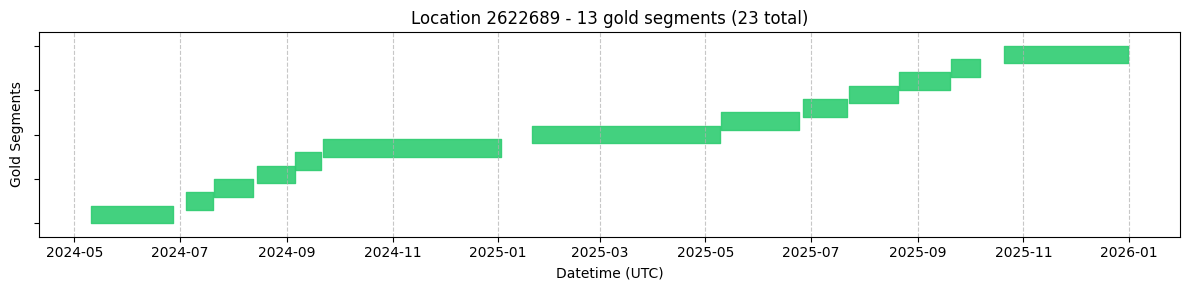

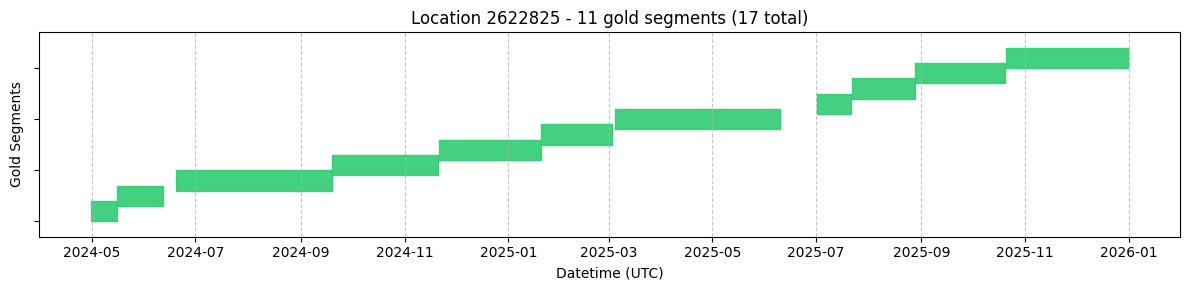

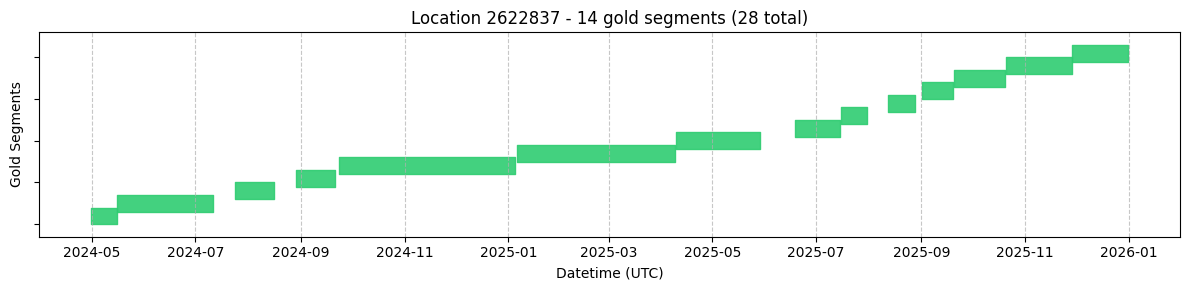

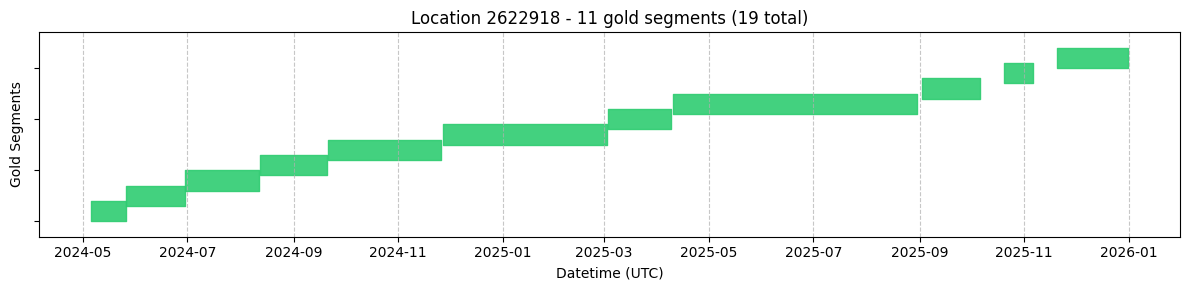

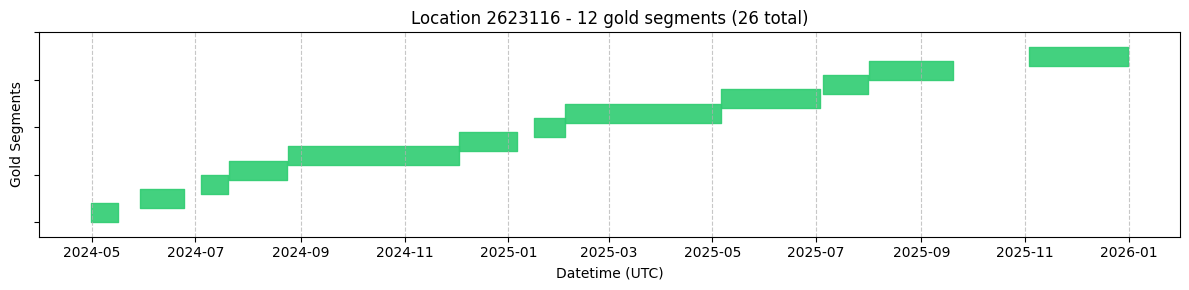

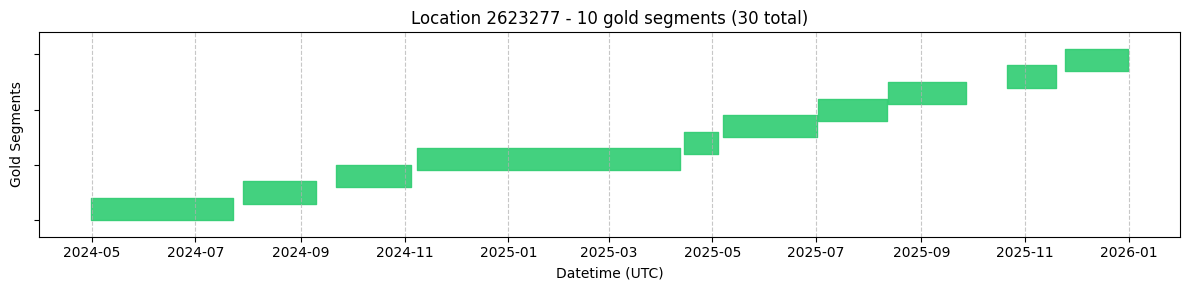

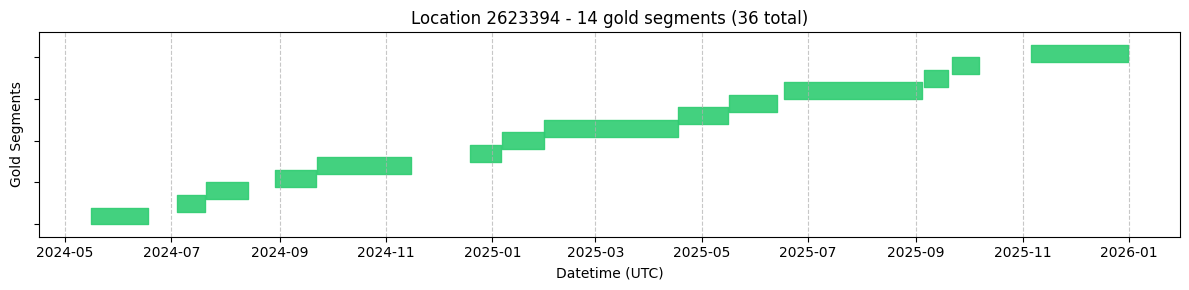

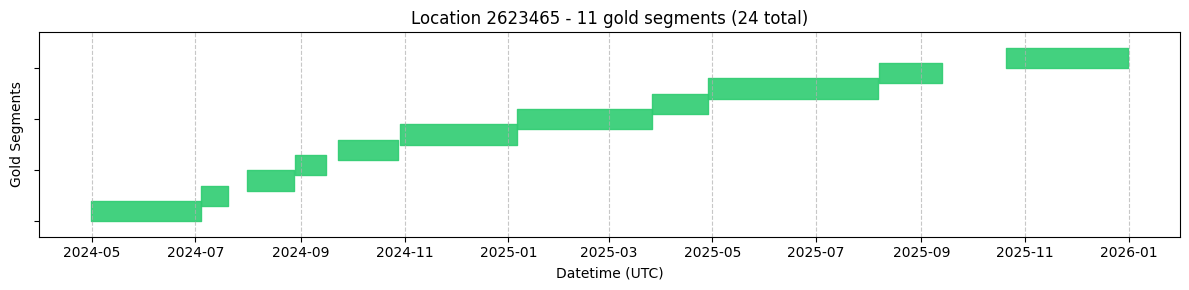

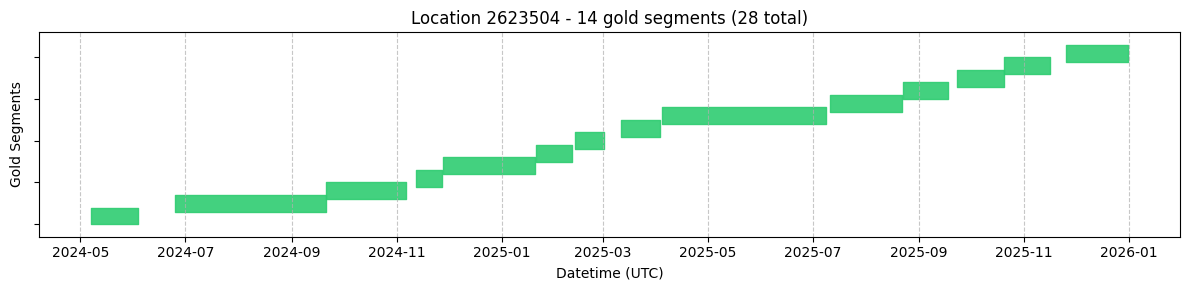

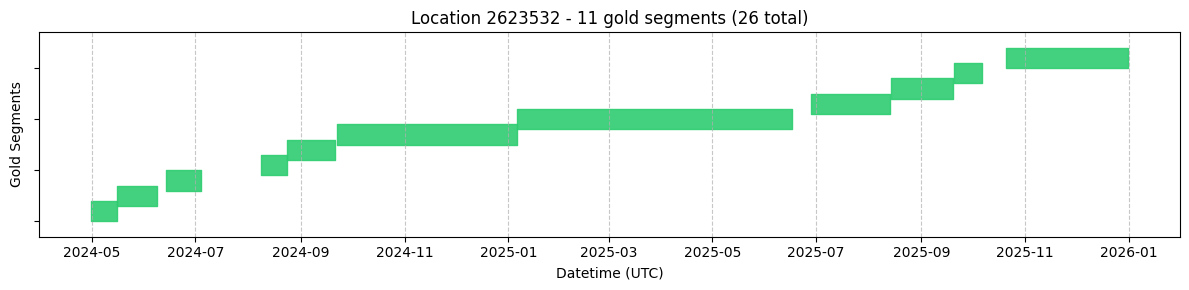

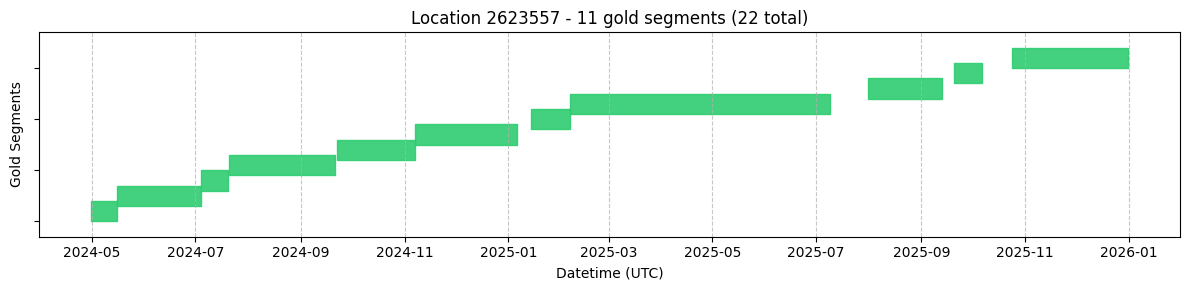

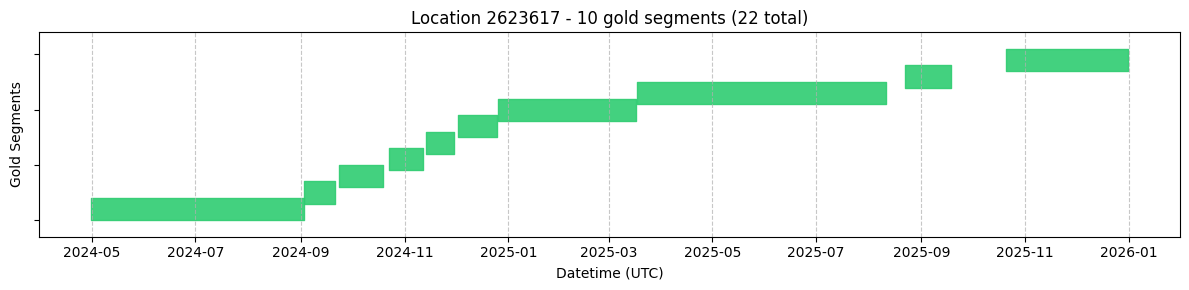

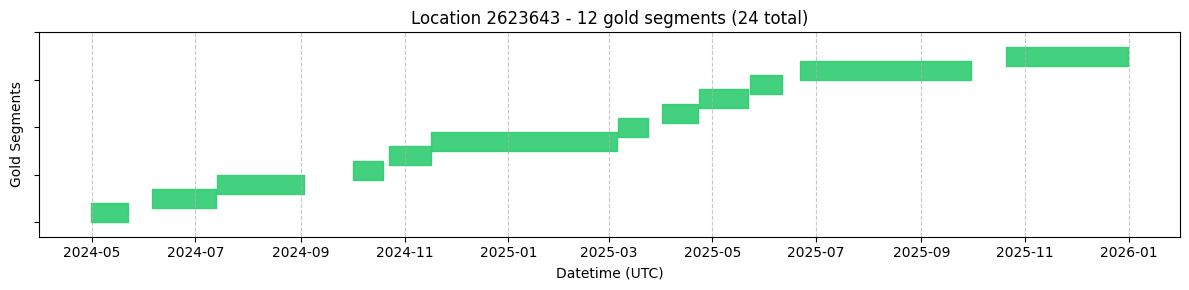

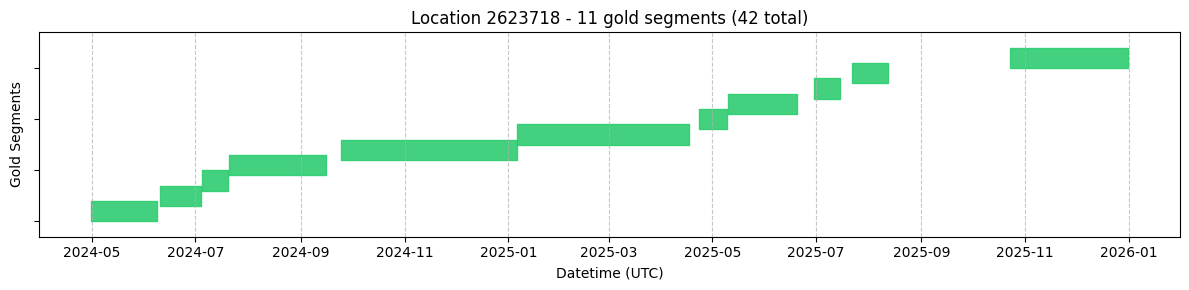

________________________________________________________________
TEST LOCATIONS SEASONAL DISTRIBUTION

> [BigQuery]: Request finished in 1.29s  ->  288 rows, 0.02 MB


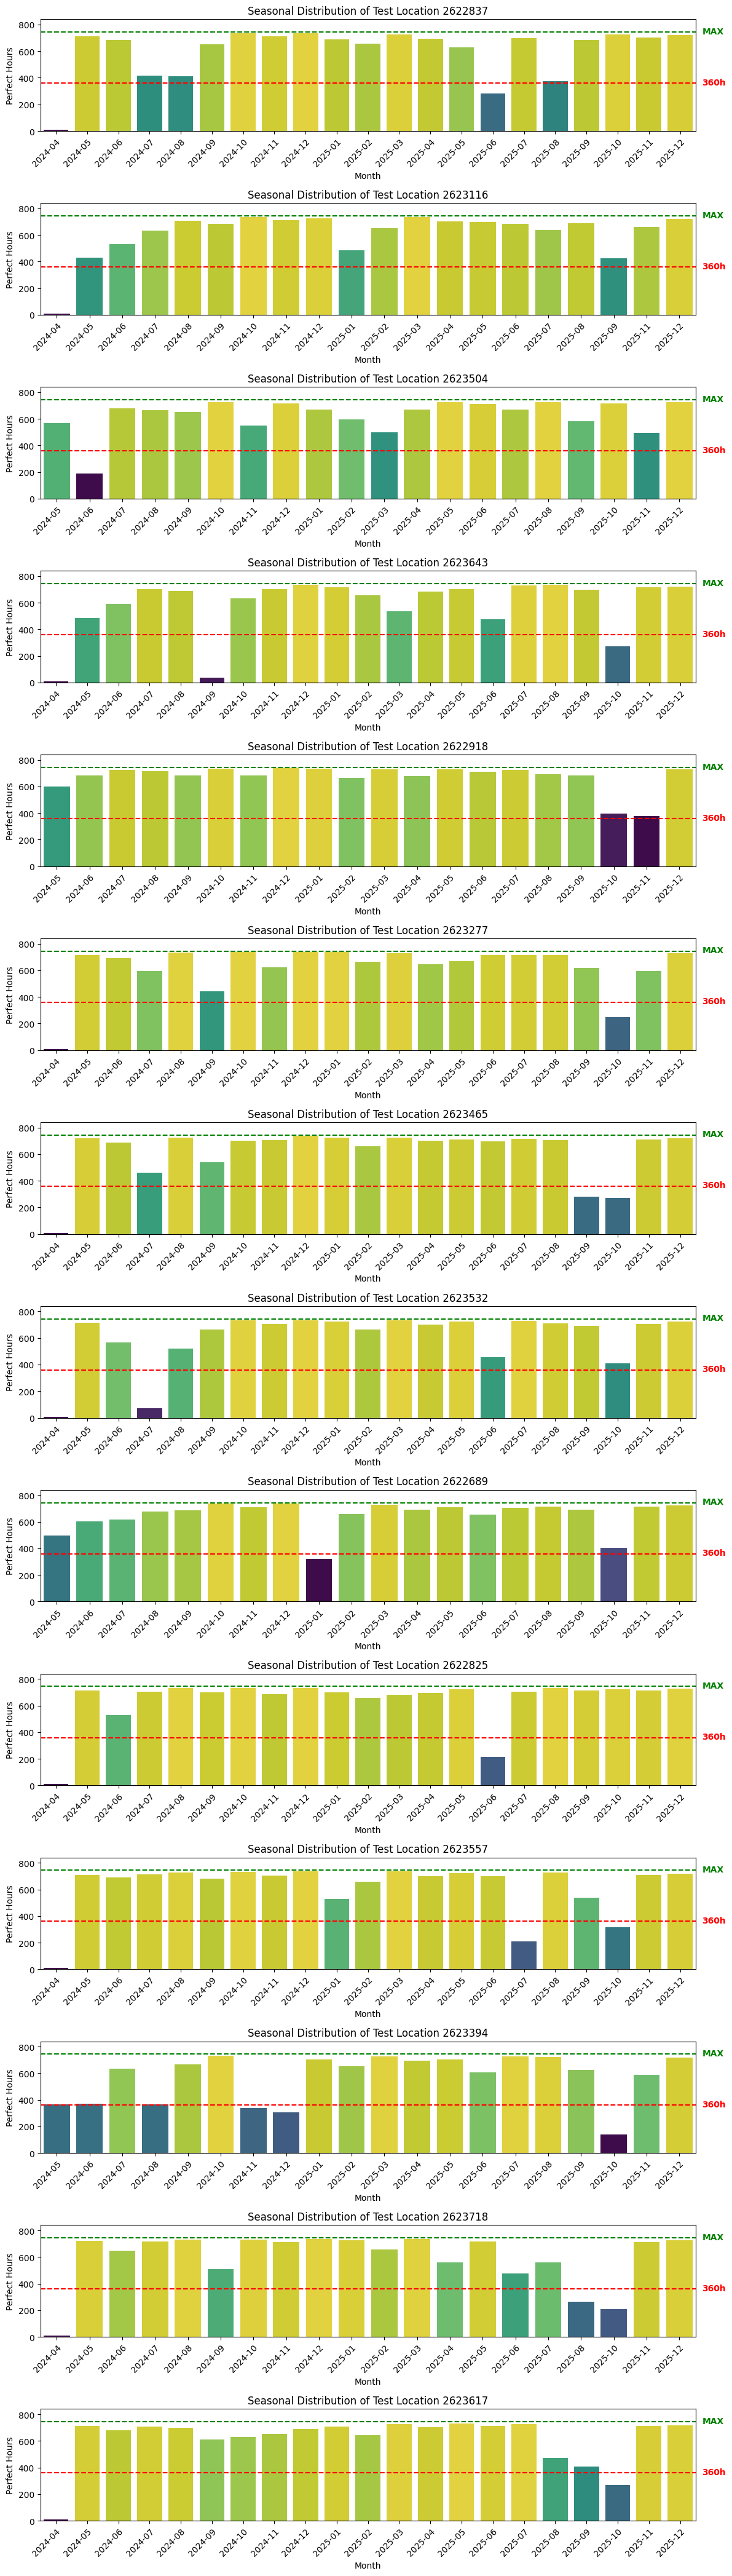

In [33]:
OLD_TEST_LOCATIONS = [
    # URBAN CORES (Traffic & Density)
    "2622837", # Rank 10 | Jung-gu (City Hall) - Historic Center (13,282 hrs)

    # HIGH TRAFFIC & HIGH-RISE BELTS
    "2623116", # Rank 43 | Songpa/Jamsil (East) - Skyscrapers & 8-lane highways (12,543 hrs)
    "2623504", # Rank 17 | Songpa/Wirye (SE) - New Town/Planned City (13,117 hrs)

    # INDUSTRIAL ZONES
    "2623643", # Rank 35 | Geumcheon (South) - Main Industrial Complex (12,701 hrs)
    "2622918", # Rank 5  | Seocho (South)- Southern Highway Barrier (13,550 hrs)
    "2622687", # Rank 72 | Gimpo Fringe (West) - SO2 Champion (10,860 hrs)

    # WESTERN WINDWARD (Yellow Dust Entry)
    "2623465", # Rank 25 | Gangseo (West) - Smog Gateway + PM10 (12,965 hrs)
    "2623532", # Rank 30 | Yangcheon (West) - Dense Residential West (12,820 hrs)

    # RESIDENTIAL BELTS
    "2622689", # Rank 13 | Nowon (North) - Northern "Bed Town" (13,210 hrs)
    "2622825", # Rank 6  | Eunpyeong (NW) - NW Residential Barrier (13,501 hrs)
    "2623557", # Rank 11 | Gwangjin (East) - Green/Urban Mix (13,282 hrs)

    # CHEMICAL STRESS TESTS (High Value + High Stability)
    "2623394", # Rank 47 | Gwanak-gu (Center) - High O3 (Mountainous/Uni area) - (12,350 hrs)
    "2623718", # Rank 45 | Eunpyeong (Center) - High NO2 Traffic Artery + CO (12,464 hrs)
    "2623617", # Rank 26 | Gangnam-gu (South) - Traffic/NO2 Champion (13,292 hrs)

    # LOCATIONS BEING DROPPED TO TRAINING
    # "2622782", # Rank 8  | Dongdaemun - High fidelity station (13,298 hrs)
    # "2623563", # Rank 28 | Guro-gu - High PM2.5 (Digital/Industrial Complex) - (12,856 hrs)
    # "2623321", # Rank 21 | Jongno (Commercial) - NO2 Hotspot + CO (13,050 hrs)
]

# [NEW AND IMPROVED] :star:
# We're doing 3 things while selecting the TEST locations:
# 1) Keep a good spatial distribution across the city
# 2) Keep a good representation of different pollution patterns
# 3) Keep the "champion" locations for high pollutants values in training
TEST_LOCATIONS = [
    # --- URBAN CORES (Historic Center) ---
    # Rank 23 Hours (12,652 hrs) | City Hall / Jung-gu (Center)
    # Good baseline for "standard" urban pollution.
    "2622837", 

    # --- HIGH TRAFFIC & HIGH DENSITY (Southeast) ---
    # Rank 31 Hours (12,263 hrs) | Songpa/Jamsil (East)
    # Represents high-rise density and arterial traffic east of Gangnam.
    "2623116", 
    # Rank 27 Hours (12,527 hrs) | Songpa/Wirye (SE)
    # New Town planning; distinct patterns from the old city.
    "2623504", 

    # --- INDUSTRIAL & HEAVY POLLUTANT ZONES ---
    # Rank 33 Hours (12,219 hrs) | Geumcheon (South)
    # CO Rank #3 | NO2 Rank #46. Major industrial complex representation.
    "2623643", 
    # Rank 4 Hours (13,407 hrs) | Seocho (South)
    # High fidelity anchor.
    "2622918", 
    # Rank 12 Hours (13,067 hrs) | Bucheon/Gyeonggi Border (South) [NEW]
    # SO2 Rank #4 | "Silver Medalist" for SO2. 
    # We keep the SO2 Champion (SW: 2623720) in TRAINING to learn the peaks.
    "2623277", 

    # --- WESTERN WINDWARD (China Inflow/Smog) ---
    # Rank 17 Hours (12,908 hrs) | Gangseo (West)
    # Critical for detecting inflow of PM and yellow dust.
    "2623465", 
    # Rank 21 Hours (12,677 hrs) | Yangcheon (West)
    # Dense residential area directly in the wind path.
    "2623532", 

    # --- RESIDENTIAL BELTS (Bed Towns) ---
    # Rank 13 Hours (12,978 hrs) | Nowon (North)
    # Representative of Northern residential density.
    "2622689", 
    # Rank 2 Hours (13,539 hrs) | Eunpyeong (North West)
    # Excellent data stability.
    "2622825", 
    # Rank 14 Hours (12,957 hrs) | Gwangjin (East)
    # CO Rank #15 | NO2 Rank #14. Good mixed-use proxy.
    "2623557", 

    # --- CHEMICAL STRESS TESTS (High Values, but not Max) ---
    # Rank 51 Hours (11,392 hrs) | Gwanak-gu (Center)
    # O3 Rank #12 | The best "High Ozone" candidate that actually has >10k hours.
    # We keep the O3 Champion (2623430) in TRAINING.
    "2623394", 
    # Rank 43 Hours (11,860 hrs) | Eunpyeong (Center)
    # NO2 Rank #1 | *EXCEPTION*
    # I am keeping this Champion in TEST because it has a very close "runner up" in the training set
    # (Gangnam 2623617 is Rank #4 NO2 and is spatially distinct, allowing for good generalization).
    "2623718", 
    # Rank 15 Hours (12,921 hrs) | Gangnam-gu (South)
    # NO2 Rank #4 | CO Rank #9 | High traffic values.
    "2623617", 
]

def train_test_split_report():
    title = "COMPARISON OF STRATEGIES OF SHATTERING / SEGMENTATION"
    print(f"{'=' * SEP_LENGTH}\n{title}\n{'='*SEP_LENGTH}\n")

    # Big Query
    start_time = time.perf_counter()
    query = """
        SELECT
            * 
            -- * EXCEPT (segment_perfect_hours, segment_perfect_density)
        FROM `openaq-anomaly-prediction.dev_intermediate.int_seoul__measurements_segments`
        --WHERE location_id = @selected_location
        ORDER BY location_id, datetimeto_utc ASC
    """
    query_parameters = [
        # ("test_locations_ids", "STRING", TEST_LOCATIONS)
        ("selected_location", "STRING", "2622586")
    ]
    segments_df = bq.query(query, query_parameters=query_parameters, dry_run=False)
    print_summary_request(segments_df, start_time, end="")

    PERFECT_GOLD_LOCATIONS = get_perfect_gold_locations(
        segments_df,
        # title_suffix=" WITH PERFECT DENSITY >= 0.9",
        # mask=(segments_df["segment_perfect_density"] >= 0.9)
    )

    TRAIN_LOCATIONS = [loc for loc in PERFECT_GOLD_LOCATIONS if loc not in TEST_LOCATIONS]

    title = f"SPATIAL TRAIN/TEST SPLIT ({len(PERFECT_GOLD_LOCATIONS)} PERFECT GOLD LOCATIONS)"
    print(f"{'=' * SEP_LENGTH}\n{title}\n{'='*SEP_LENGTH}\n")
        
    print(f"TRAIN LOCATIONS: {len(TRAIN_LOCATIONS)} locations:\n{TRAIN_LOCATIONS}\n")
    print(f"TEST LOCATIONS: {len(TEST_LOCATIONS)} locations:\n{TEST_LOCATIONS}\n")

    assert_train_test_split_analysis(
        train_locations=TRAIN_LOCATIONS,
        test_locations=TEST_LOCATIONS,
        perfect_gold_locations=PERFECT_GOLD_LOCATIONS,
        show_appendix=False
    )
    
    assert_plot_segments_overview(
        segments_df[segments_df["location_id"].isin(TEST_LOCATIONS)],
        title_suffix=f": GOLD SEGMENTS COVERAGE ({len(TEST_LOCATIONS)} TEST LOCATIONS)"
    )
    assert_train_test_split_seasonal_distribution(locations_ids=TEST_LOCATIONS)

train_test_split_report()

### ***↪***&nbsp;&nbsp;**Maps**

TODO:
- MAPS: Add a number grid over all municipalities to identify them from an attached legend
- CHLOROPLETH MAP: add a municipality column for each location

#### Map Preload (settings)

In [37]:
# ================================================================
# MAPS PRELOAD (DF + GEOJSON)

# SEOUL City
import requests

repo_url = "https://raw.githubusercontent.com/southkorea/southkorea-maps/master/kostat/2018/json/skorea-provinces-2018-geo.json"
seoul_geojson = {
    "type": "FeatureCollection",
    "features": [
        f for f in requests.get(repo_url).json()['features']
        if f['properties'].get('name') == 'Seoul'
        or f['properties'].get('name_en') == 'Seoul'
        or f['properties'].get('name') == '서울특별시'
    ]
}

# SEOUL Municipalities
repo_url = "https://raw.githubusercontent.com/southkorea/seoul-maps/master/kostat/2013/json/seoul_municipalities_geo_simple.json"
repo_url = "https://raw.githubusercontent.com/southkorea/seoul-maps/refs/heads/master/juso/2015/json/seoul_municipalities_geo_simple.json"
seoul_geojson_districts = requests.get(repo_url).json()

#### Map functions (customization)

In [38]:
# ================================================================
# CUSTOMIZE COLORAXIES (COLOR SCHEMES) AND COLORBAR (LEGEND)

def customize_colorbar(option: str = "vertical", **kwargs) -> dict:
    if option == "vertical":
        x = kwargs.get("x", 0.90)
        y = kwargs.get("y", 0.80)
        len = kwargs.get("len", 0.3)
        thickness = kwargs.get("thickness", 15)

        return dict(
            # tickmode="array",
            # tickvals=[0, 10, 20, 30, 40, 50, 100],
            # ticktext=["0", "10", "20", "30", "40", "50", "100+"],
            x=x,
            y=y,
            len=len,
            thickness=thickness,
            bgcolor="rgba(255,255,255, 1)",
            bordercolor="white",
            borderwidth=1,
            title=dict(text=""),
            # tickfont=dict(size=12)
        )
    else:
        x = kwargs.get("x", 0.87)
        y = kwargs.get("y", 0.06)
        len = kwargs.get("len", 0.23)
        thickness = kwargs.get("thickness", 10)

        return dict(
            orientation="h",
            x=x,
            y=y,
            len=len,
            thickness=thickness,
            bgcolor="rgba(255,255,255, 1)",
            bordercolor="white",
            title=dict(text=""),
            # tickfont=dict(size=12)
        )

    return fig

def customize_coloraxes(point_coloraxis: list, border_coloraxis: list, **kwargs) -> dict:
    cmin = kwargs.get("cmin", 0)
    cmax = kwargs.get("cmax", None)

    return {
        # Point coloraxis
        "coloraxis": dict(
            colorscale=point_coloraxis,
            cmin=cmin,
            cmax=cmax,
            # colorbar=customize_colorbar(option="vertical")
        ),
        # Border coloraxis
        "coloraxis2": dict(
            colorscale=border_coloraxis,
            cmin=cmin,
            cmax=cmax,
            showscale=False
        )
    }


# ================================================================
# CUSTOMIZE MAP LAYERS (GEOJSON)

def customize_map_layers(city_geojson: dict, seoul_geojson_districts: dict | None = None, option: str = "default", **kwargs) -> list:
    color = kwargs.get("color", "")
    dimmer_color = kwargs.get("dimmer_color", "rgba(0, 0, 0, 0.2)")
    glowing_border = kwargs.get("glowing_border", False)

    border_color = kwargs.get("border_color", "white")
    border_width = kwargs.get("border_width", 2)

    sub_border_color = kwargs.get("sub_border_color", "rgba(0,0,0,0.4)")
    sub_border_width = kwargs.get("sub_border_width", 2)
    sub_dashes = kwargs.get("sub_dashes", [2, 2])

    map_layers = []

    # Create the Mask geojson
    world_coords = [[-180, -90], [180, -90], [180, 90], [-180, 90], [-180, -90]]
    city_coords = city_geojson['features'][0]['geometry']['coordinates']
    mask_geojson = {
        "type": "FeatureCollection",
        "features": [{
            "type": "Feature",
            "geometry": {
                "type": "Polygon",
                "coordinates": [world_coords] + city_coords if isinstance(city_coords[0][0], list) else [world_coords, city_coords[0]]
            },
            "properties": {}
        }]
    }

    if option == "default":
        map_layers = [
            # LAYER 1: The "Dimmer" (Everything EXCEPT Seoul)
            {
                "sourcetype": "geojson",
                "source": mask_geojson,
                "type": "fill",
                "color": f"{dimmer_color}", # Darken the rest of the world
                "below": "traces",
            },
            # LAYER 3: The Thick White Border for Seoul
            # {
            #     "sourcetype": "geojson",
            #     "source": city_geojson,
            #     "type": "line",
            #     "color": "rgba(255, 255, 255, 1)",
            #     "line": {"width": 2},
            #     "below": "traces"
            # },
            # # LAYER 4: Dim Seoul (less)
            # {
            #     "sourcetype": "geojson",
            #     "source": seoul_geojson,
            #     "type": "fill",
            #     "color": "rgba(0, 0, 0, 0.1)", # Darken Seoul
            #     "below": "traces"
            # },
        ]

        # LAYER: The Seoul Municipalities
        if seoul_geojson_districts is not None:
            map_layers.append({
                "sourcetype": "geojson",
                "source": seoul_geojson_districts,
                "type": "line",
                "color": f"{sub_border_color}",
                "line": {
                    "width": sub_border_width,
                    "dash": sub_dashes,  # [dash length, gap length]
                },
                "below": "traces",
            })

        # BORDER: Seoul Borders
        if glowing_border:
            glow_layers = []
            for width, opacity in zip([2, 5, 10, 15], [0.8, 0.4, 0.2, 0.1]):
                glow_layers.append({
                    "sourcetype": "geojson",
                    "source": city_geojson,
                    "type": "line",
                    "color": f"rgba(255, 255, 255, {opacity})",
                    "line": {"width": width},
                    "below": "traces"
                })
            map_layers.extend(glow_layers)
        else:
            map_layers.extend([{
                "sourcetype": "geojson",
                "source": city_geojson,
                "type": "line",
                "color": border_color,
                "line": {"width": border_width},
                "below": "traces"
            }])

    return map_layers


# ================================================================
# CUSTOMIZE POINTS

# TODO: Add an exponential "size" feature for both the size of the points and the colors
def customize_points(fig: PlotlyFigure, df: pd.DataFrame, lat: str, lon: str, **kwargs) -> PlotlyFigure:
    color = kwargs.get("color", None)
    size_column = kwargs.get("size", None)
    size_max = kwargs.get("size_max", 24)
    border = kwargs.get("border", size_column is None)

    hover_name = kwargs.get("hover_name", None)
    hover_data = kwargs.get("hover_data", None)

    exponential = kwargs.get("exponential", False)

    # Reset all traces
    fig.data = []

    border_scaling_ratio = 1.5
    base_point_size = 16

    point_size = base_point_size if size_column is None else 0
    border_size = int(point_size*border_scaling_ratio) if size_column is None else None

    df_plot = df

    # EXPONENTIAL MODE
    if exponential and size_column:
        # Example: Square the values to create exponential visual scaling
        df_plot[size_column + "_exp"] = df_plot[size_column] ** 2
        size_column = size_column + "_exp"
        if hover_data is not None:
            hover_data[size_column] = False

    # FIXED SIZE (settings)
    if size_column is None:
        border_settings = {
            "coloraxis": "coloraxis2",
            "size": border_size if not size_column else None,
            "color": "white",
        }
        marker_settings = {
            "coloraxis": "coloraxis",
            "size": point_size,
        }
    # SCALED SIZE (settings)
    else:
        border_settings = {
            "coloraxis": "coloraxis2",
            # color="white",
            # opacity=0.8,
            # sizemode='area' if size else None,
            # sizeref=calc_sizeref if size else None,
        }
        marker_settings = {
            "coloraxis": "coloraxis",
            "sizemode": "area",
            # sizeref=calc_sizeref if size else None,
            "sizemin": 4
        }

    # BORDER: larger bottom/border layer
    if border:
        border_fig = px.scatter_map(
            df_plot, lat=lat, lon=lon,
            color=color,
            size=size_column,
            size_max=size_max + 8 if size_column is not None else None,
        )
        border_fig.update_traces(marker=border_settings)
        for trace in border_fig.data:
            fig.add_trace(trace)
        # border_trace = px.scatter_map(
        #     df_plot, lat=lat, lon=lon,
        #     color=color,
        #     size=size_column,
        #     size_max=size_max + 8 if size_column is not None else None,
        # ).data[0]
        # border_trace.marker.update(border_settings)
        # fig.add_trace(border_trace)

    # POINT/MARKER: slightly smaller top/fill layer
    fill_fig = px.scatter_map(
        df_plot, lat=lat, lon=lon,
        opacity=1,  # force settings
        color=color,
        size=size_column,
        size_max=size_max,
        hover_name=hover_name,
        hover_data=hover_data,

    )
    fill_fig.update_traces(marker=marker_settings)
    for trace in fill_fig.data:
        fig.add_trace(trace)
    # fill_trace = px.scatter_map(
    #     df_plot, lat=lat, lon=lon,
    #     opacity=1,  # force settings
    #     color=color,
    #     size=size_column,
    #     size_max=size_max,
    #     hover_name=hover_name,
    #     hover_data=hover_data,

    # ).data[0]
    # fill_trace.marker.update(marker_settings)
    # fig.add_trace(fill_trace)

    return fig

# ================================================================
# CUSTOMIZE TITLE

def customize_title(title: str, **kwargs):
    upper = kwargs.get("upper", True)

    if upper:
        title = title.upper()

    return [
        dict(
            text="<b>&nbsp;{}&nbsp;</b>".format(title),
            xref="paper",
            yref="paper",
            x=0.02,
            y=0.98,
            # x=0.,  # Slight padding from the left edge
            # y=1.,  # Slight padding from the top edge
            showarrow=False,
            font=dict(
                size=16,
                color="rgba(255, 255, 255, 0.9)",
                family="Arial"
            ),
            align="left",
            bgcolor="rgba(0, 0, 0, 0.4)", # Optional: subtle background for readability
            borderpad=10,
            bordercolor="rgba(255, 255, 255, 0.9)",
            borderwidth=3,
        )
    ]

# ================================================================
# MAPS COLOR SCALES

KOREAN_FLAG_CS = [
    # TIER 1: Deep Ink (0% - 25%)
    [0.0,  "rgba(20, 20, 20, 0.1)"],
    [0.25, "rgba(20, 20, 20, 0.2)"],

    # TIER 2: Official Blue (25% - 50%)
    [0.25, "rgba(0, 71, 160, 0.6)"],
    [0.5,  "rgba(0, 71, 160, 0.7)"],

    # TIER 3: Royal Yellow (50% - 75%)
    [0.5,  "rgba(255, 209, 103, 0.8)"],
    [0.75, "rgba(255, 209, 103, 0.8)"],

    # TIER 4: Cinnabar Red (75% - 100%)
    [0.75, "rgba(205, 46, 58, 0.8)"],
    [1.0,  "rgba(205, 46, 58, 0.8)"]
]

KOREAN_FLAG_CS_SWAP = [
    # TIER 1: Deep Ink (0% - 25%)
    [0.0,  "rgba(20, 20, 20, 0.1)"],
    [0.25, "rgba(20, 20, 20, 0.2)"],

    # TIER 3: Royal Yellow (50% - 75%)
    [0.25,  "rgba(255, 209, 103, 0.6)"],
    [0.5, "rgba(255, 209, 103, 0.7)"],

    # TIER 2: Official Blue (25% - 50%)
    [0.5, "rgba(0, 71, 160, 0.8)"],
    [0.75,  "rgba(0, 71, 160, 0.8)"],
    
    # TIER 4: Cinnabar Red (75% - 100%)
    [0.75, "rgba(205, 46, 58, 0.8)"],
    [1.0,  "rgba(205, 46, 58, 0.8)"]
]

KOREAN_FLAG_CS_GOLD = [
    # TIER 1: Deep Ink (0% - 25%)
    [0.0,  "rgba(20, 20, 20, 0.1)"],
    [0.25, "rgba(20, 20, 20, 0.2)"],

    # TIER 2: Official Blue (25% - 50%)
    [0.25, "rgba(0, 71, 160, 0.6)"],
    [0.5,  "rgba(0, 71, 160, 0.7)"],

    # TIER 3: Royal Yellow (50% - 75%)
    [0.5,  "rgba(205, 46, 58, 0.8)"],
    [0.75, "rgba(205, 46, 58, 0.8)"],

    # TIER 4: Cinnabar Red (75% - 100%)
    [0.75, "rgba(255, 209, 103, 0.8)"],
    [1.0,  "rgba(255, 209, 103, 0.8)"]
]

KOREAN_FLAG_LIGHT_CS = [
    # TIER 1: Deep Ink (0% - 25%)
    [0.0,  "rgba(255, 255, 255, 0.4)"],
    [0.25, "rgba(255, 255, 255, 0.5)"],

    # TIER 2: Official Blue (25% - 50%)
    [0.25, "rgba(0, 71, 160, 0.6)"],
    [0.5,  "rgba(0, 71, 160, 0.7)"],

    # TIER 3: Royal Yellow (50% - 75%)
    [0.5,  "rgba(255, 209, 103, 0.8)"],
    [0.75, "rgba(255, 209, 103, 0.8)"],

    # TIER 4: Cinnabar Red (75% - 100%)
    [0.75, "rgba(205, 46, 58, 0.8)"],
    [1.0,  "rgba(205, 46, 58, 0.8)"]
]

WHITE_TRANSPARENT_CS = [
    # TIER 1: Invisible/Low (0% - 20%)
    [0.0, "rgba(255, 255, 255, 0)"],   # Fully transparent
    [0.2, "rgba(255, 255, 255, 0.2)"], # Faint white "ghost" points

    # TIER 2: Cool/Stable (20% - 50%)
    [0.2, "rgba(255, 255, 255, 0.5)"],    # Start Official Blue (50% Opacity)
    [0.5, "rgba(255, 255, 255, 0.6)"],

    # TIER 3: Warning/Center (50% - 80%)
    [0.5, "rgba(255, 255, 255, 0.9)"],  # Start Royal Yellow (90% Opacity)
    [0.8, "rgba(255, 255, 255, 0.9)"],

    # TIER 4: Critical/Peak (80% - 100%)
    [0.8, "rgba(255, 255, 255, 0.9)"],    # Start Cinnabar Red (Fully Opaque)
    [1.0, "rgba(255, 255, 255, 0.9)"]
]

AQI_PALETTE = [
    [0.0, 'rgba(0, 228, 0, 0)'],      # Clean/Zero: Transparent Green
    [0.2, 'rgba(255, 255, 0, 0.4)'],  # Moderate: Translucent Yellow
    [0.5, 'rgba(255, 126, 0, 0.7)'],  # Unhealthy: Orange
    [0.8, 'rgba(255, 0, 0, 0.9)'],    # Very Unhealthy: Red
    [1.0, 'rgba(143, 63, 151, 1)']    # Hazardous: Solid Purple
]

TOXIC_PALETTE = [
    [0.0, 'rgba(0, 255, 255, 0)'],    # Baseline: Transparent Cyan
    [0.3, 'rgba(173, 255, 47, 0.3)'], # Low: Green-Yellow
    [0.6, 'rgba(255, 255, 0, 0.6)'],  # Mid: Bright Yellow
    [1.0, 'rgba(255, 0, 255, 1)']     # Peak: Solid Magenta/Pink
]

THERMAL_PALETTE = [
    [0.0, 'rgba(255, 245, 240, 0)'],  # Start: Transparent White
    [0.2, 'rgba(254, 224, 210, 0.3)'], # Light Peach
    [0.5, 'rgba(252, 146, 114, 0.6)'], # Soft Coral
    [0.8, 'rgba(222, 45, 38, 0.8)'],   # Strong Red
    [1.0, 'rgba(103, 0, 13, 1)']       # Peak: Deep Maroon
]

#### Maps: Scatter/Density/Chloropleth

In [39]:
perfect_locations_df = assert_locations_ranking_per_perfect_hours(show_appendix=False)

LOCATIONS RANKING BASED ON PERFECT HOURS (GOLD SEGMENTS ONLY)

> [BigQuery]: Request finished in 1.33s  ->  116 rows, 0.01 MB




In [40]:
# ================================================================
# SCATTER MAP

perfect_locations_df["location_type"] = perfect_locations_df["location_id"].apply(
    # lambda x: x in str(OLD_TEST_LOCATIONS)
    lambda x: x in str(TEST_LOCATIONS)
    # lambda x: 2 if x in O3_CHAMPIONS else (1 if x in str(FRUGAL_BEST_LOCATIONS) else 0)
)
# display(perfect_locations_df.head(200))

fig = px.scatter_map(perfect_locations_df, lat="location_latitude", lon="location_longitude")

# Customize points
fig = customize_points(
    fig,
    perfect_locations_df,
    lat="location_latitude",
    lon="location_longitude",
    color="location_type",
    # size="perfect_hour_measurements",
    size_max=96,
    exponential=True,
    hover_name="location_id",
    hover_data={
        "location_id": True,
        # "location_municipality": True,
        # "nan_count": True,
        # "nan_pct": ":.2%",
        "location_latitude": False,
        "location_longitude": False,
        "location_perfect_hours": True,
        "location_type": True,
    },
)

fig.update_layout(
    width=1024,
    height=760,
    margin={"r":0,"t":0,"l":0,"b":0},
    # map_style="satellite-streets",  # ['basic', 'carto-darkmatter', 'carto-darkmatter-nolabels', 'carto-positron', 'carto-positron-nolabels', 'carto-voyager', 'carto-voyager-nolabels', 'dark', 'light', 'open-street-map', 'outdoors', 'satellite', 'satellite-streets', 'streets', 'white-bg']
    map_style="satellite",  # ['basic', 'carto-darkmatter', 'carto-darkmatter-nolabels', 'carto-positron', 'carto-positron-nolabels', 'carto-voyager', 'carto-voyager-nolabels', 'dark', 'light', 'open-street-map', 'outdoors', 'satellite', 'satellite-streets', 'streets', 'white-bg']
    # map_style="basic",  # ['basic', 'carto-darkmatter', 'carto-darkmatter-nolabels', 'carto-positron', 'carto-positron-nolabels', 'carto-voyager', 'carto-voyager-nolabels', 'dark', 'light', 'open-street-map', 'outdoors', 'satellite', 'satellite-streets', 'streets', 'white-bg']
    map_zoom=10.3,
    map_center={"lat": 37.55414276122411, "lon": 126.97022422324727},

    annotations=customize_title("SEOUL - Scatter Map", upper=False),
    **customize_coloraxes(
        KOREAN_FLAG_CS, WHITE_TRANSPARENT_CS,
        # cmax=perfect_locations_df["perfect_hour_measurements"].max()
        cmax=2
    ),
    # coloraxis_colorbar=customize_colorbar(option="vertical", x=0.91, y=0.82),
    coloraxis_colorbar=customize_colorbar(option="horizontal"),
    map_layers=customize_map_layers(
        seoul_geojson,
        seoul_geojson_districts,
        border_color="rgba(255, 255, 255, 1)", border_width=4,
        sub_border_color="rgba(160, 160, 160, 0.4)", sub_border_width=2, sub_dashes=[3,2],
        dimmer_color="rgba(80, 80, 80, 0.4)", glowing_border=False,
    )
)

In [38]:
# # ================================================================
# # DENSITY MAP

# filtered_locations = locations[locations["nan_pct"] > 0.]
# # print(len(filtered_locations))

# base_multiplier = 1.5
# dynamic_radius = base_multiplier * (2 ** (10.1 / 2)) # Approx 45-60 for Seoul at zoom 10

# fig = px.density_map(
#     filtered_locations,
#     lat="latitude",
#     lon="longitude",
#     z="nan_count",
#     radius=150,
#     color_continuous_scale=AQI_PALETTE,
#     range_color=[0, filtered_locations["nan_count"].max()],
# )
# fig.update_traces(below='')
# fig.update_layout(
#     width=1024,
#     height=760,
#     margin={"r":0,"t":0,"l":0,"b":0},
#     map_style="basic",  # ['basic', 'carto-darkmatter', 'carto-darkmatter-nolabels', 'carto-positron', 'carto-positron-nolabels', 'carto-voyager', 'carto-voyager-nolabels', 'dark', 'light', 'open-street-map', 'outdoors', 'satellite', 'satellite-streets', 'streets', 'white-bg']
#     map_zoom=10.3,
#     map_center={"lat": 37.55414276122411, "lon": 126.97022422324727},

#     annotations=customize_title("SEOUL - Density Map", upper=False),
#     # **customize_coloraxes(KOREAN_FLAG_CS, WHITE_TRANSPARENT_CS, cmax=filtered_locations["nan_count"].max()),
#     coloraxis_colorbar=customize_colorbar(option="horizontal"),
#     map_layers=customize_map_layers(
#         seoul_geojson,
#         seoul_geojson_districts,
#         border_color="rgba(255, 255, 255, 1)", border_width=4,
#         sub_border_color="rgba(160, 160, 160, 0.4)", sub_border_width=2, sub_dashes=[3,2],
#         dimmer_color="rgba(80, 80, 80, 0.4)", glowing_border=False,
#     )
# )

In [39]:
# # ================================================================
# # CHROLOPLETH MAP

# filtered_locations = locations[locations["nan_pct"] > 0.]
# # print(len(filtered_locations))

# # Need to map each location coodinates with a GeoJSON municipality
# print(f"{seoul_geojson_districts['features'][0]['properties']}\n")

# fig = px.choropleth_map(
#     filtered_locations,
#     geojson=seoul_geojson_districts,
#     locations="location_id",
#     featureidkey="SIG_ENG_NM",
#     # featureidkey="SIG_CD",
#     color="nan_count",
#     opacity=0.7,
#     # lat="latitude",
#     # lon="longitude",
#     # z="nan_count",
#     # radius=50,
#     color_continuous_scale=AQI_PALETTE,
#     # range_color=[0, filtered_locations["nan_count"].max()],
# )
# fig.update_traces(below='')
# fig.update_layout(
#     width=1024,
#     height=760,
#     margin={"r":12,"t":12,"l":12,"b":12},
#     map_style="basic",  # ['basic', 'carto-darkmatter', 'carto-darkmatter-nolabels', 'carto-positron', 'carto-positron-nolabels', 'carto-voyager', 'carto-voyager-nolabels', 'dark', 'light', 'open-street-map', 'outdoors', 'satellite', 'satellite-streets', 'streets', 'white-bg']
#     map_zoom=10.3,
#     map_center={"lat": 37.55414276122411, "lon": 126.97022422324727},

#     annotations=customize_title("SEOUL - Chloropleth Map", upper=False),
#     # **customize_coloraxes(KOREAN_FLAG_CS, WHITE_TRANSPARENT_CS, cmax=filtered_locations["nan_count"].max()),
#     coloraxis_colorbar=customize_colorbar(option="horizontal"),
#     map_layers=customize_map_layers(
#         seoul_geojson,
#         seoul_geojson_districts,
#         border_color="rgba(255, 255, 255, 1)", border_width=4,
#         sub_border_color="rgba(160, 160, 160, 0.4)", sub_border_width=2, sub_dashes=[3,2],
#         dimmer_color="rgba(80, 80, 80, 0.4)", glowing_border=False,
#     )
# )

In [ ]:
# ---------------------------------------------------------------------
# Unload the dataframes
perfect_locations_df = None
del perfect_locations_df
unreachable = gc.collect()